### Máster en Ciencia de Datos - CUNEF

### Trabajo Final de Máster

### Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación

Alba Rodríguez Berenguel

### Descripción del problema

Este código forma parte del trabajo final del máster en ciencia de datos en el que se pondrán en práctica todos los conocimientos adquiridos en las distintas asignaturas. Como se indica en el título 'Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación', el objetivo es conseguir un modelo que sea capaz de clasificar transacciones bancarias en fraudulentas o no fraudulentas, así como poder conocer cuáles son las variables que más ayudan a la clasificación.

Para ello, voy a llevar a cabo todas las fases de un proyecto de Machine Learning: análisis y limpieza de los datos, transformaciones, selección variables y modelado. En la fase de modelado, contruiré distintos modelos con la finalidad de poder compararlos y ver cuál devuelve resultados más precisos.

El fraude afecta en muchos sectores y sigue creciendo diariamente, por lo que es una gran preocupación. Los modelos de ML son una de las soluciones que mejores resultados están reportando en la detección del fraude, por lo que son muy útiles y se pueden llegar a aplicar en entidades bancarias, proveedoras de tarjetas bancarias, páginas de e-commerce, entre otras. 

### Descripción del dataset

Los datos se han obtenido de la plataforma Kaggle (https://www.kaggle.com/competitions/ieee-fraud-detection/), que pone a disposición de los usuarios un gran repositorio con conjuntos de datos de diversos temas. Concretamente, los datos seleccionados fueron publicados para un concurso organizado por el IEEE en colaboración con Vesta, una de las compañias pioneras en la proporción de soluciones para la prevención del fraude.

Son dos conjuntos de datos: Transaction y Identity. El primero contiene información sobre las transacciones y el segundo sobre los usuarios, tienen una columna común con la que se pueden relacionar. Cabe destacar que no hay una explicación concreta de todas las variables, ya que muchas de ellas están anonimizadas para preservar la privacidad de los usuarios, por lo que no se puede conocer qué información aportan exactamente. En el diccionario de datos se amplia todo lo que se sabe acerca de las distintas variables.

La variable objetivo es *isfraud* y hace referencia a si una transacción es fraudulenta o no, está codificada con 1 si es fraude y 0 si no lo es.

Este es el primer notebook del proyecto, en el que se va a llevar a cabo un **análisis exploratorio** de los datos para tener un conocimiento más amplio de los mismos y realizar algunas transformaciones iniciales si fuese necesario. El esquema que se va a seguir es el siguiente:

1. Carga de los datos.
2. Análisis general de la tabla.
3. Exploración de la variable target y tratamiento.
4. Tratamiento de valores missing.
5. Variables categóricas.
6. Variables numéricas.
7. Exportación de los datos.

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import warnings
import datetime
warnings.filterwarnings('ignore')

In [2]:
# Functions
def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return (stat/(obs*mini))

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_outlier_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(
                drop=True).sort_values(by=['porcentaje_sum_outlier_values'], ascending=False)
            
    if pd_final.empty:
        print('No existen variables con valores outliers')
        
    return pd_final

def reduce_group(grps,c='v'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = fraud_df[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
        use.append(vx)
    print('Las columnas a mantener son:',use)

## 1. Carga de los datos

In [3]:
# I parameterize the names of the files to read.
train_identity = "../data/raw/train_identity.csv"
test_identity = "../data/raw/test_identity.csv"
train_transaction = "../data/raw/train_transaction.csv"
test_transaction = "../data/raw/test_transaction.csv"

# I'm only going to read the train files, because test files don't have isFraud column.
identity_df = pd.read_csv(train_identity)
transaction_df = pd.read_csv(train_transaction)

# I join identity and transaction df by the column they have in common (TransactionID). I specify 'outer' so that all 
# transaction rows are kept because identity is a smaller data set and does not contain all id's.
fraud_df = pd.merge(transaction_df, identity_df, on='TransactionID', how='outer')

# I convert the names of all the columns to lower case, to facilitate their treatment.
fraud_df = fraud_df.rename(columns=str.lower)

fraud_df.head()

transactionid  isfraud  transactiondt  transactionamt productcd  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  devicetype  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      deviceinfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

## 2. Análisis general de la tabla

In [4]:
# I check the shape of the datasets, to make sure that they have been correct. 
print(identity_df.shape)
print(transaction_df.shape)
print(fraud_df.shape)

(144233, 41)
(590540, 394)
(590540, 434)


El dataset resultante de la unión tiene **434 variables y 590540 filas**

In [5]:
# I check for duplicate values.
print(fraud_df.shape, fraud_df.drop_duplicates().shape)

(590540, 434) (590540, 434)


A la izquierda está la dimensión del df y a la derecha si se eliminasen los valores duplicados. Se puede ver que **no hay duplicados**, puesto que la dimensión es la misma.

In [6]:
# I remove the transactionid column because it is the identifier of each transaction and it will not contribute anything 
#to the models. Its main utility was to relate both datasets.
fraud_df = fraud_df.drop('transactionid', axis=1)

In [7]:
# I check the types of the variables.
fraud_df.dtypes.to_dict()

{'isfraud': dtype('int64'),
 'transactiondt': dtype('int64'),
 'transactionamt': dtype('float64'),
 'productcd': dtype('O'),
 'card1': dtype('int64'),
 'card2': dtype('float64'),
 'card3': dtype('float64'),
 'card4': dtype('O'),
 'card5': dtype('float64'),
 'card6': dtype('O'),
 'addr1': dtype('float64'),
 'addr2': dtype('float64'),
 'dist1': dtype('float64'),
 'dist2': dtype('float64'),
 'p_emaildomain': dtype('O'),
 'r_emaildomain': dtype('O'),
 'c1': dtype('float64'),
 'c2': dtype('float64'),
 'c3': dtype('float64'),
 'c4': dtype('float64'),
 'c5': dtype('float64'),
 'c6': dtype('float64'),
 'c7': dtype('float64'),
 'c8': dtype('float64'),
 'c9': dtype('float64'),
 'c10': dtype('float64'),
 'c11': dtype('float64'),
 'c12': dtype('float64'),
 'c13': dtype('float64'),
 'c14': dtype('float64'),
 'd1': dtype('float64'),
 'd2': dtype('float64'),
 'd3': dtype('float64'),
 'd4': dtype('float64'),
 'd5': dtype('float64'),
 'd6': dtype('float64'),
 'd7': dtype('float64'),
 'd8': dtype('float

Los tipos con los que se han cargado las variables son esos. En la página web de la que se han descargado se indicaban los tipos correctos, y las variables categóricas son las siguientes:

- productcd
- card1 - card6
- addr1, addr2
- p_emaildomain
- r_emaildomain
- m1 - m9
- deviceType
- deviceInfo
- id_12 - id_38
- isfraud

El resto de las variables son tipo float o integer. Más adelante los analizaremos y cambiaremos si es necesario.

## 3. Exploración de la variable target y tratamiento

La variable target es *isfraud* que hace referencia a si una transacción es fraudulenta o no. Toma el valor 1 si es fraude y 0 en caso contrario.

In [8]:
# Firstly, I am going to position the target variable to the right of the dataset.
# I extract the column.
mov_card = fraud_df.pop('isfraud')

# I insert it as the last column.
fraud_df.insert(len(fraud_df.columns), "isfraud", mov_card)

In [9]:
# I add the values for each category (0 and 1) and calculate their percentage.
fraud_df_percent = fraud_df['isfraud']\
        .value_counts(normalize = True)\
        .mul(100).rename('percent').reset_index()

# I add the values for each category (0 and 1).
fraud_df_count = fraud_df['isfraud'].value_counts().reset_index()

# I join the previous results.
fraud_df_concat = pd.merge(fraud_df_percent, 
                                  fraud_df_count, on=['index'], how='inner')

fraud_df_concat

index    percent  isfraud
0      0  96.500999   569877
1      1   3.499001    20663

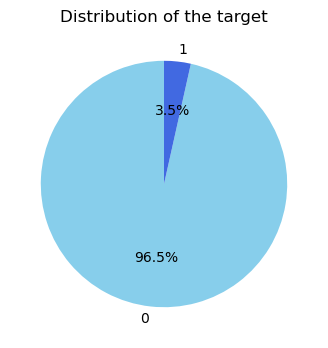

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
lab = ['0', '1']
perc = fraud_df_concat['percent']
ax.pie(perc, labels=lab, colors=['skyblue', 'royalblue'], autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of the target')
plt.show()

Como conclusión a los cálculos y al gráfico, se puede afirmar que **el dataset está excesivamente desbalanceado** en favor de las transacciones no fraudulentas (0). **El 96,50% de las transacciones que se analizan en este dataset no son fraude y solo el 3,50% lo son.**

## 4. Tratamiento de valores missing 

### 4.1. Nulos por columnas

In [11]:
# I calculate the nulls by columns and the percentage
fraud_df_null_columns = fraud_df.isnull().sum().sort_values(ascending=False).to_frame('columns_null').reset_index()
fraud_df_null_columns['columns_percentage'] = fraud_df_null_columns['columns_null']/fraud_df.shape[0] * 100

fraud_df_null_columns

index  columns_null  columns_percentage
0      id_24        585793           99.196159
1      id_25        585408           99.130965
2      id_07        585385           99.127070
3      id_08        585385           99.127070
4      id_21        585381           99.126393
..       ...           ...                 ...
428      c10             0            0.000000
429      c11             0            0.000000
430      c12             0            0.000000
431      c13             0            0.000000
432  isfraud             0            0.000000

[433 rows x 3 columns]

Hay columnas con un elevado porcentaje de valores nulos, lo que podría afectar al modelo. El dataset tiene 434 columnas, por lo que se podría eliminar un número considerable de variables, puesto que disponemos de suficientes como para construir un modelo. **Se van a eliminar todas aquellas que tengan más de un 50% de valores nulos** (unas 300.000 filas), ya que es un número elevado como para imputar tantos datos, podría afectar a la variable. El resto de columnas con valores nulos se tratarán más adelante.

In [12]:
# I create a list with the columns that have more than 50% null values
cols_to_drop = fraud_df_null_columns.loc[fraud_df_null_columns['columns_percentage'] > 50, 'index'].tolist()

# I remove the selected columns
fraud_df = fraud_df.drop(cols_to_drop, axis=1)

### 4.2. Nulos por filas

In [13]:
# I calculate the nulls by rows, if there is any row with the variable target null and the percentage of nulls of each row
fraud_df_null_rows = fraud_df.isnull().sum(axis=1).sort_values(ascending=False)
fraud_df_null_rows = pd.DataFrame(fraud_df_null_rows, columns=['rows_null']) 
fraud_df_null_rows['target'] = fraud_df['isfraud'].copy()
fraud_df_null_rows['rows_percentage']= fraud_df_null_rows['rows_null']/fraud_df.shape[1] * 100

fraud_df_null_rows

rows_null  target  rows_percentage
456104        140       0        63.926941
456122        139       0        63.470320
474061        139       0        63.470320
474362        139       0        63.470320
474068        139       0        63.470320
...           ...     ...              ...
243278          0       0         0.000000
243280          0       0         0.000000
503144          0       0         0.000000
243282          0       0         0.000000
295270          0       0         0.000000

[590540 rows x 3 columns]

El valor más alto de nulos que encontramos en las filas ronda el 63% lo que equivale a unas 139 - 140 variables faltantes en una transaccion. **Se van a eliminar aquellas observaciones que tienen más de un 50% de valores nulos, dado que no son demasiadas y apenas afecta al dataset.**

In [14]:
nulls_50 = list(fraud_df_null_rows.index[fraud_df_null_rows['rows_percentage'] > 50])

fraud_df = fraud_df.drop(index = nulls_50)

fraud_df.shape

(590472, 219)

Tras eliminar las columnas y filas con más de un 50% de nulos, el dataset resultante tiene 219 variables y 590472 filas.

## 5. Variables categóricas

Las variables categóricas según la información que hay sobre el dataset son las siguientes:

- productcd: Código de producto, el producto de cada transacción.
- card1 - card6: Información de la tarjeta, como el tipo, la categoría, el banco, el país, etc.
- addr1 y addr2: Región y país de facturación.
- p_emaildomain: Dominio de email del comprador.
- m1, m2, m3, m4 y m6: Verificación de coincidencia de los datos, por ejemplo el código telefónico con el código postal, los datos personales del cliente, la dirección, etc.
- isfraud (variable target)

Por otra parte, han indicado que algunas de las variables nombradas como v[...] explican relación entre entidades, por lo que podrían ser binarias y se deberían tratar como categóricas. Para ello, se van a buscar aquellas que solo tienen como valores únicos el 0 y el 1.

In [15]:
# I create a loop to search for the variables v[...] that are binary, those that have unique values 0 and 1.
# I add them to var_binary list.
var_binary = []
for col in fraud_df.columns:
    if fraud_df[col].nunique() == 2 and set([0, 1]) == set(fraud_df[col].dropna().unique()):
        var_binary.append(col)

In [16]:
# I create a list with the other categorical variables.
var_category = [
               'productcd', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'p_emaildomain',
               'm1', 'm2', 'm3', 'm4', 'm6'
               ]

# I join two list
var_category.extend(var_binary)

# I change the type to object to make sure they have the correct type.
fraud_df[var_category] = fraud_df[var_category].astype("object")

In [17]:
# I check the number of unique values of each variable.
for i in fraud_df[var_category]:
    print(i, fraud_df[i].nunique())

productcd 5
card1 13548
card2 500
card3 114
card4 4
card5 119
card6 4
addr1 332
addr2 74
p_emaildomain 59
m1 2
m2 2
m3 2
m4 3
m6 2
v1 2
v14 2
v41 2
v65 2
v88 2
v107 2
isfraud 2


In [18]:
# I check the unique values of each variable.
for i in fraud_df[var_category]:
    print(i, fraud_df[i].unique())

productcd ['W' 'H' 'C' 'S' 'R']
card1 [13926 2755 4663 ... 17972 13166 8767]
card2 [nan 404.0 490.0 567.0 514.0 555.0 360.0 100.0 111.0 352.0 375.0 418.0
 303.0 314.0 543.0 583.0 148.0 321.0 269.0 361.0 272.0 399.0 569.0 453.0
 417.0 512.0 545.0 266.0 114.0 481.0 452.0 547.0 383.0 170.0 343.0 556.0
 285.0 562.0 302.0 264.0 558.0 500.0 396.0 103.0 206.0 143.0 243.0 476.0
 199.0 174.0 423.0 446.0 492.0 523.0 440.0 528.0 161.0 535.0 354.0 117.0
 455.0 325.0 158.0 268.0 122.0 479.0 147.0 215.0 480.0 265.0 388.0 408.0
 309.0 415.0 414.0 437.0 104.0 225.0 101.0 134.0 586.0 191.0 491.0 369.0
 322.0 494.0 532.0 313.0 474.0 324.0 475.0 298.0 429.0 432.0 553.0 566.0
 599.0 296.0 251.0 310.0 242.0 204.0 250.0 270.0 346.0 316.0 194.0 587.0
 390.0 135.0 536.0 254.0 226.0 327.0 420.0 260.0 413.0 428.0 561.0 387.0
 411.0 392.0 203.0 297.0 136.0 276.0 142.0 527.0 210.0 184.0 459.0 118.0
 585.0 106.0 588.0 449.0 176.0 177.0 246.0 439.0 503.0 445.0 172.0 468.0
 239.0 496.0 364.0 533.0 370.0 578.0 150.0 

Voy a representar algunas de las variables que tienen menos valores únicos para ver qué categorías están más afectadas por el fraude y conocer el comportamiento de los estafadores.

#### Fraude según producto

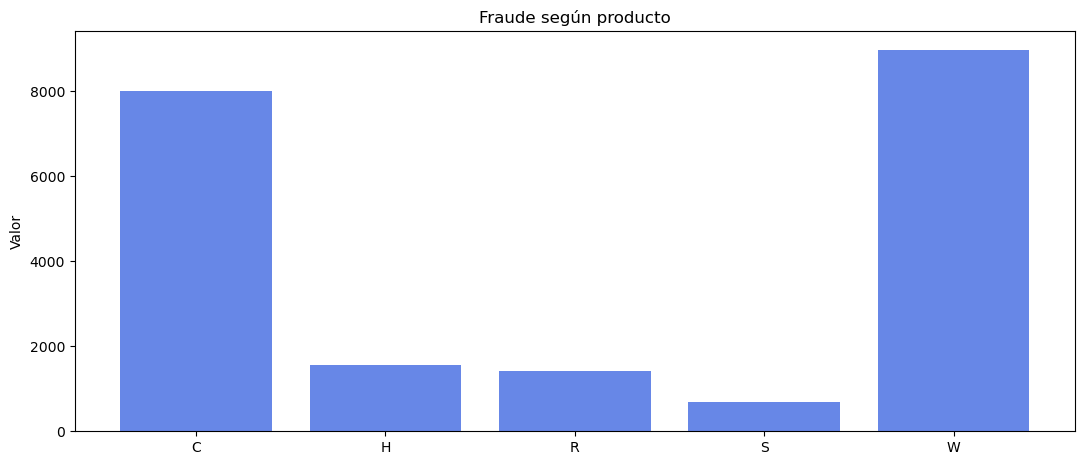

In [19]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['productcd', 'isfraud']].groupby('productcd')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['productcd'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según producto')
ax.set_ylabel('Valor')
plt.show()

Esta variable hace referencia al código de producto, cada uno de ellos representa el tipo de producto que ha sido objeto en la transacción. No hay información disponible sobre qué producto concreto representa cada valor, pero podemos ver que los *C* y *W* son en los que más fraude se producen y los *S* los que menos.

#### Fraude según proveedor de tarjeta

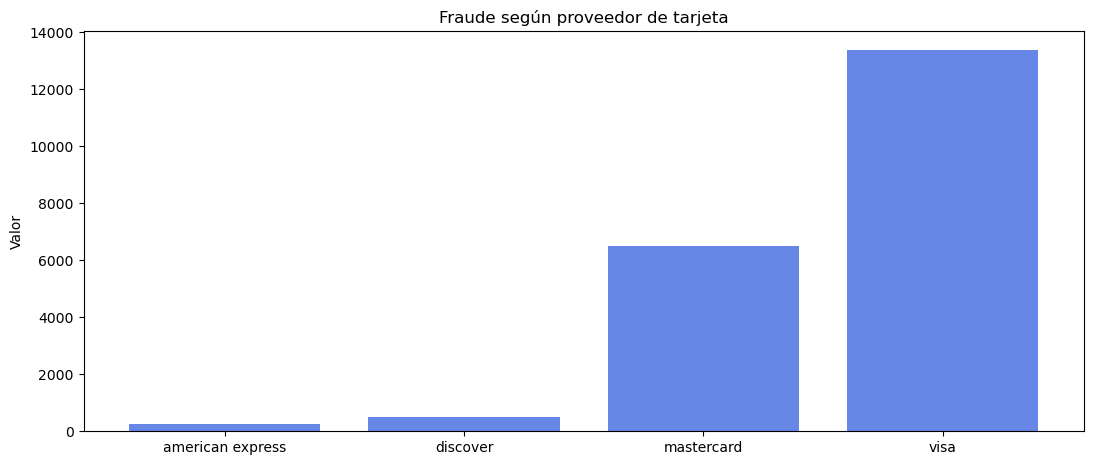

In [20]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['card4', 'isfraud']].groupby('card4')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['card4'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según proveedor de tarjeta')
ax.set_ylabel('Valor')

plt.show()

Esta variable indica el proveedor de la tarjeta que se ha usado en la transacción: *american express*, *discover*, *mastercard* o *visa*. Las tarjetas mastercard y visa son con las que más fraudes se realizan y las american express con las que menos.

#### Fraude según tipo de tarjeta

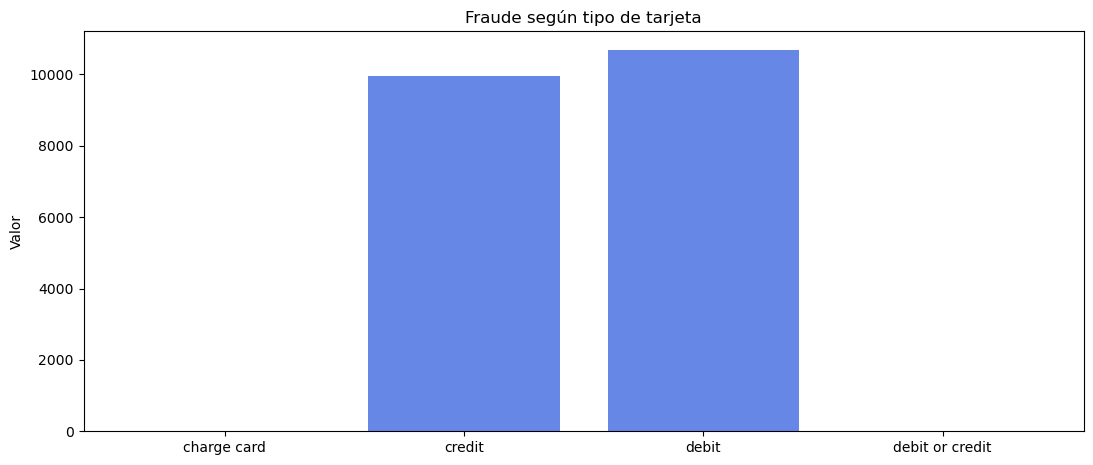

In [21]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['card6', 'isfraud']].groupby('card6')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['card6'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según tipo de tarjeta')
ax.set_ylabel('Valor')

plt.show()

Esta variable hace referencia al tipo de tarjeta que se ha usado en la transacción. Hay cuatro categorías: crédito (credit), débito (debit), recarga (charge card) y, por último, crédito o débito (debit or credit) para transacciones que no está claro el tipo de tarjeta. Las de débito son las más usadas para el fraude y las de crédito también tienen un alto porcentaje. En las otras dos categorías no se han producido fraudes, en el caso de las tarjetas recargables tiene sentido puesto que su principal objetivo es evitarlo, ya que sus usuarios las recargan exclusivamente con la cantidad a gastar.

#### Fraude según mx variables

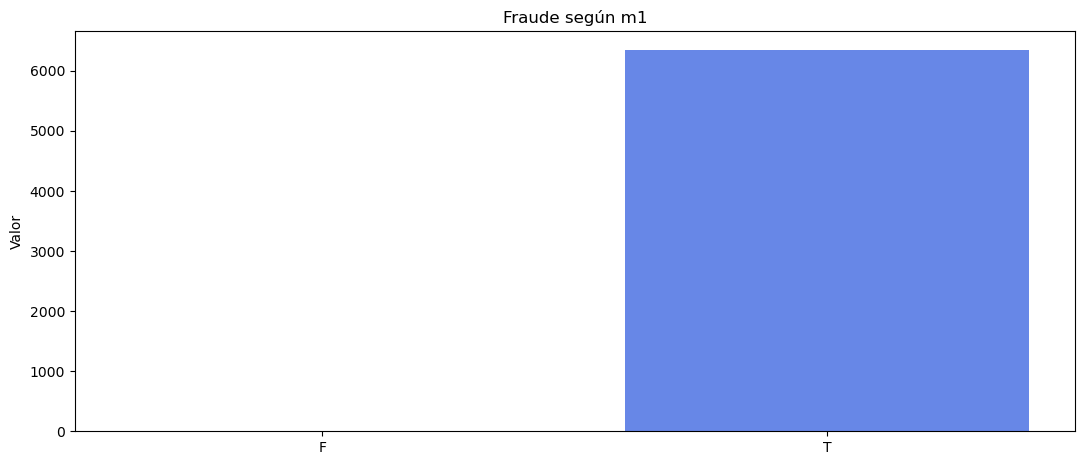

In [22]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['m1', 'isfraud']].groupby('m1')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['m1'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según m1')
ax.set_ylabel('Valor')
plt.show()

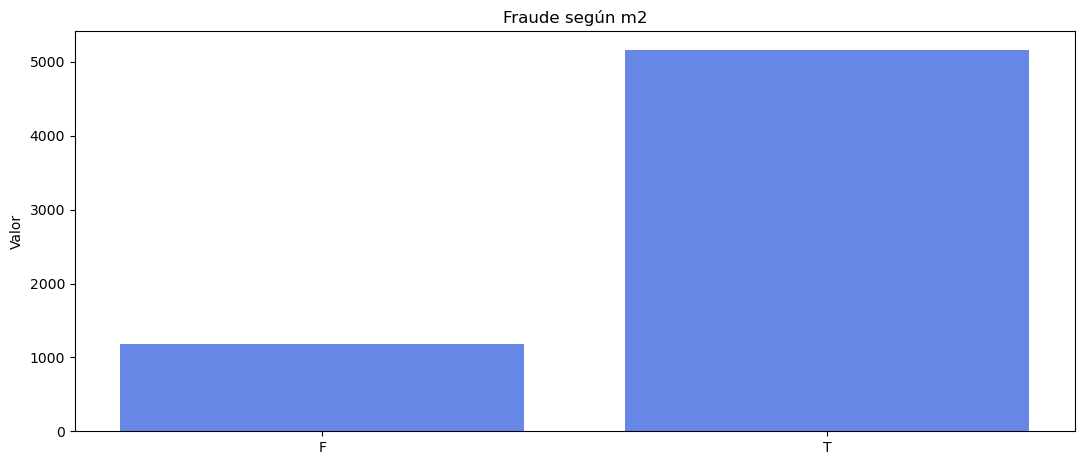

In [23]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['m2', 'isfraud']].groupby('m2')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['m2'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según m2')
ax.set_ylabel('Valor')
plt.show()

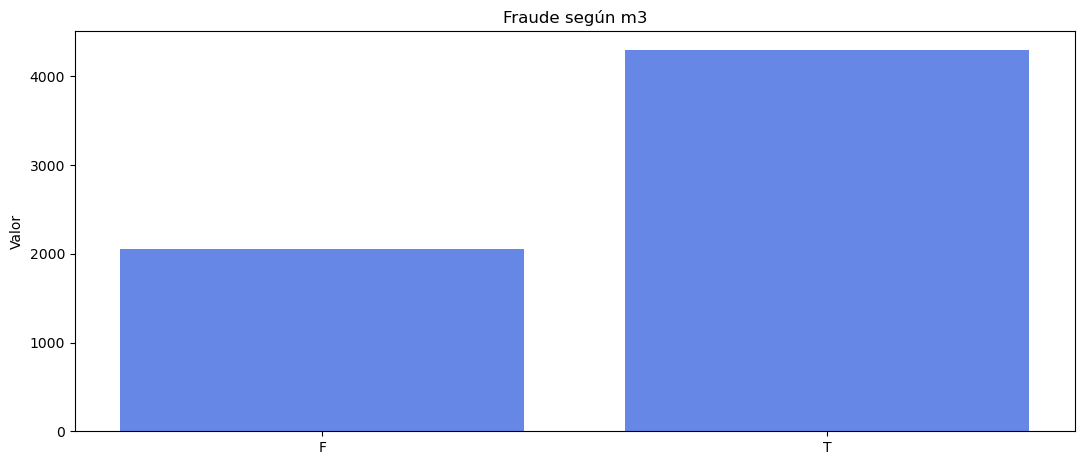

In [24]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['m3', 'isfraud']].groupby('m3')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['m3'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según m3')
ax.set_ylabel('Valor')
plt.show()

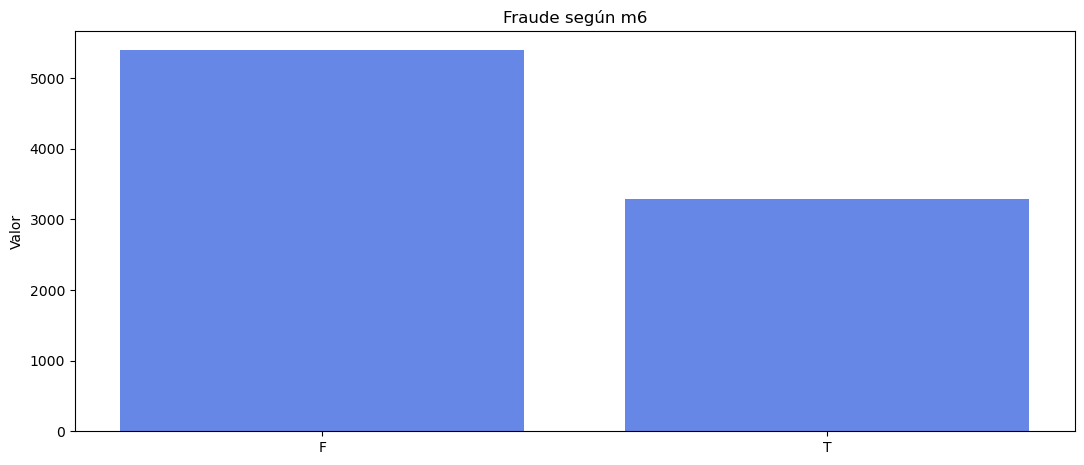

In [25]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
fraud_productcd = fraud_df[['m6', 'isfraud']].groupby('m6')['isfraud'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])
lab = list(fraud_productcd['m6'])
fraud = fraud_productcd['isfraud']
ax.bar(lab, fraud, color = 'royalblue', alpha=0.8)
ax.set_title('Fraude según m6')
ax.set_ylabel('Valor')
plt.show()

Estas variables se van a analizar conjuntamente dado que no se dispone de información concreta de cada una, solo se conoce que realizan una verificación de los datos, como ya se ha indicado. Toman el valor T (True) si coinciden y False (F) si no.

Por lo tanto, se puede comprobar que la mayoría de los datos personales suelen coincider, dado que *m1, m2 y m3* alcanzan los valores más altos en True, mientras que *m6* lo hace en False. Es probable que el dato no coincidente corresponda a la dirección porque los estafadores suelen obtener toda la información de los usuarios y envian los productos comprados a otra dirección para beneficiarse de ellos.

Como conclusión:

- Los productos C y W son con los que más se realizan fraudes.
- Los proveedores de tarjetas más afectados son Visa y Mastercard.
- Los tipos de tarjeta más utilizadas en fraude son las de crédito y las de debito.
- La mayoría de datos introducidos en la transacción coinciden con los introducidos por los usuarios. Es decir, los estafadores suelen conseguir toda la información personal de la víctima.

### 5.1. Correlación V de Cramer

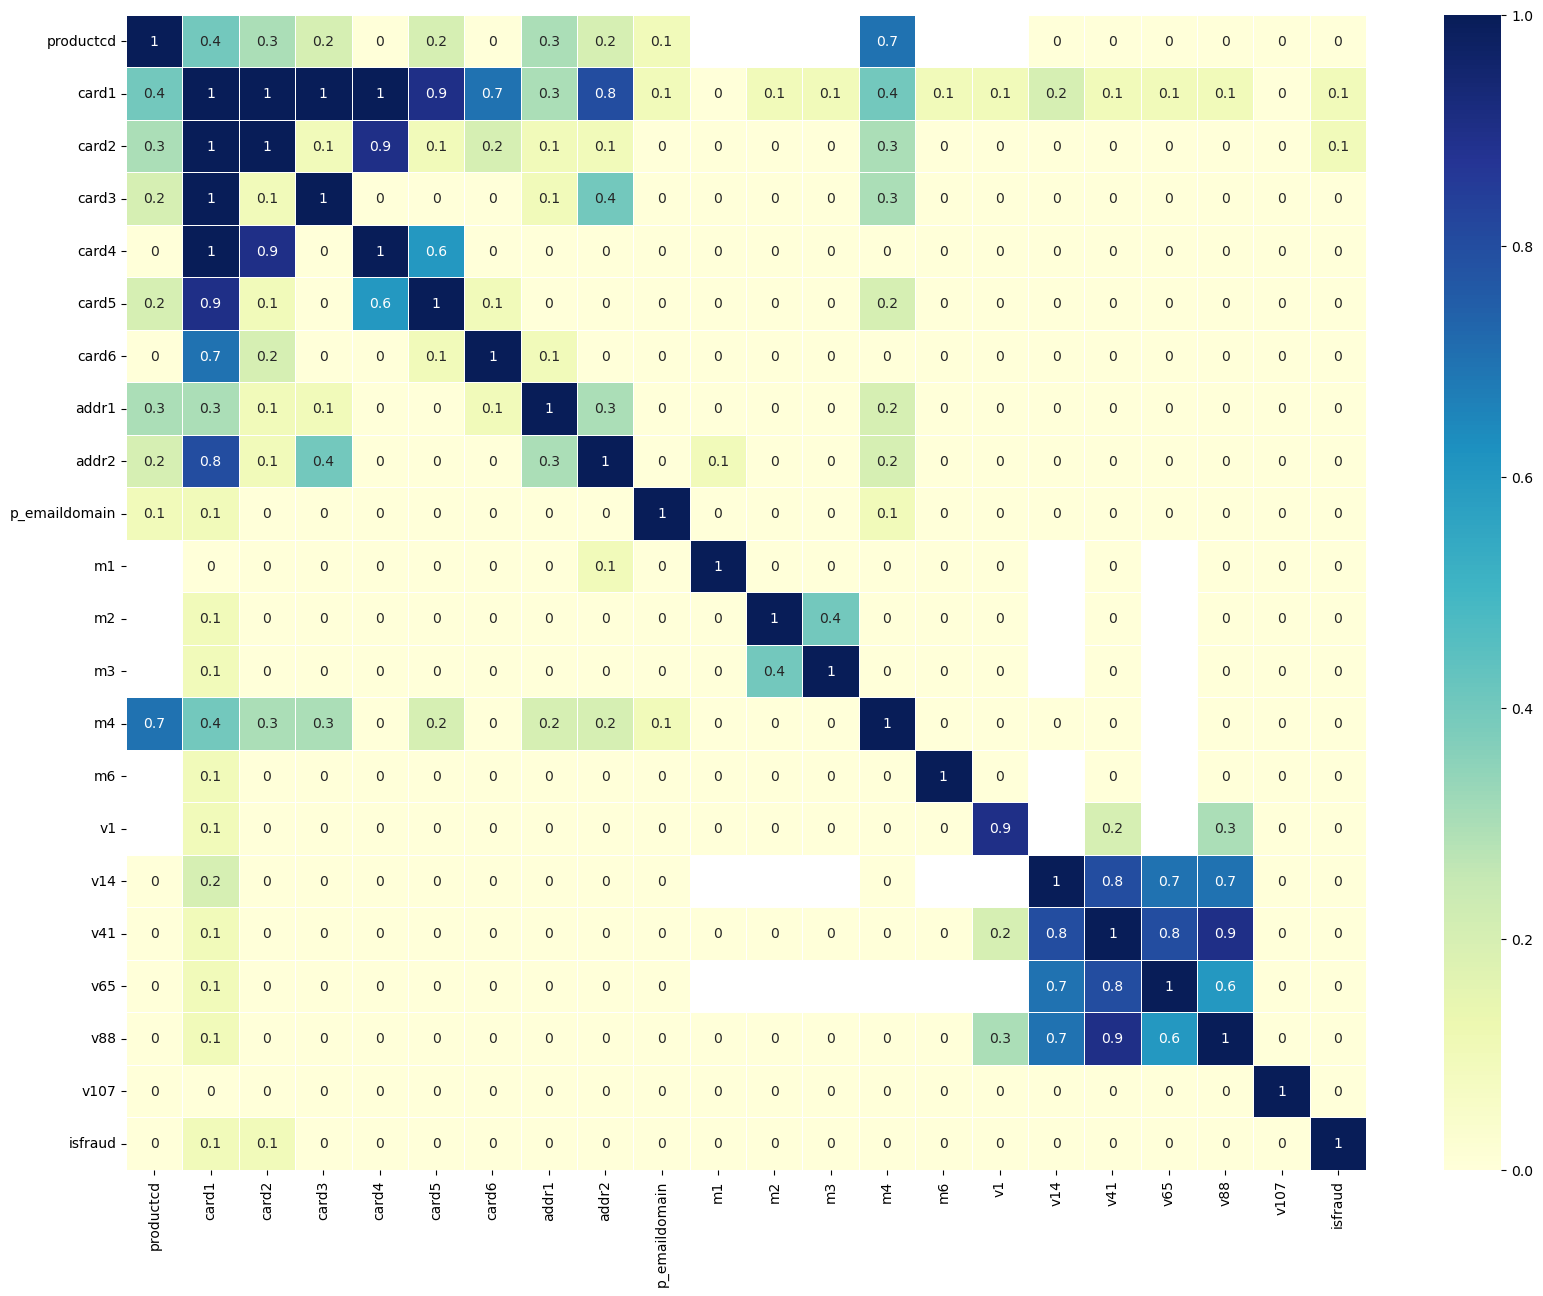

In [26]:
rows= []

for i1 in var_category:
    col = []
    for i2 in var_category:
        cramers = cramers_V(fraud_df[i1], fraud_df[i2])
        col.append(round(cramers,1))  
    rows.append(col)
    
cramers_results = np.array(rows)
v_c = pd.DataFrame(cramers_results, columns = var_category, index = var_category)

plt.figure(figsize=(20,15))
sns.heatmap(v_c, cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

Dada la alta correlación entre la variable card1 y card2, card3, card4 y card5, se va a eliminar card1 porque aunque no se tiene claro su significado, tiene un número muy elevado de valores para ser categórica y es posible que las otras variables contengan la información de esta y de ahí su alta correlación.

Esta misma situación se da con las variables binarias *v41* - *v88*, por lo que se se va a eliminar una de ellas, puesto que la información podría ser redundante y afectar al modelo. **Descartamos v41**.

In [27]:
# I drop card1 and v41 column
fraud_df = fraud_df.drop(['card1', 'v41'], axis=1)

## 6. Variables numéricas

Como ya se ha comentado antes, la mayoría de las variables están anonimizadas, por lo que solo tenemos una idea general del siginificado de su significado:

- transactiondt: tiempo en segundos desde el período de tiempo de referencia en el que comienzan los datos (no actual).
- transactionamt: cantidad de la transacción en dólares.
- c1 - c14: Conteo de datos, como por ejemplo el número de direcciones asociada a la tarjeta.
- d1 - d15: Diferencia de tiempos, como por ejemplo los días entre transacciones anteriores.
- vx: Ranking, conteo y relaciones entre entidades.

A continuación se van a visualizar algunas de las variables que se consideran más interesantes y de las que se conoce su significado.

En primer lugar, se va a visualizar la evolución a lo largo del tiempo. **Esto se puede obtener con la columna transactiondt que es la diferencia en segundos desde el día que comienzan los datos hasta el momento en el que se realiza la transacción.**

En la información del dataset han publicado que los datos dan comienzo entre noviembre - diciembre de 2017. Se va a establecer como fecha de inicio el 01/12/2017.

In [28]:
# Define start date
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')

# Create a column with date and hour
fraud_df['transaction_date'] = fraud_df['transactiondt'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

# Calculate the day of the transaction
fraud_df['transaction_day'] = (fraud_df['transaction_date'] - startdate).dt.days

# Calculate the hour of the transaction
fraud_df['transaction_hour'] = fraud_df['transaction_date'].dt.hour

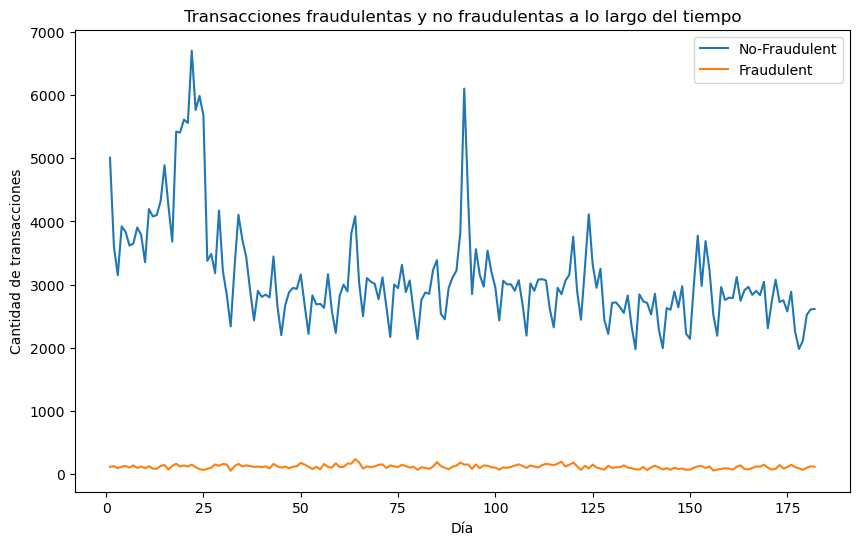

In [29]:
fraud_df.groupby(['isfraud', 'transaction_day']).size().unstack(level=0).plot(kind='line', figsize = (10,6))
plt.title('Transacciones fraudulentas y no fraudulentas a lo largo del tiempo')
plt.xlabel('Día')
plt.ylabel('Cantidad de transacciones')
plt.legend(['No-Fraudulent', 'Fraudulent'])
plt.savefig('evolucion_transaccion.jpg')

plt.show()

En términos generales no hay un comportamiento exacto para el número de transacciones que se han realizado cada día. Si se aprecia un claro aumento a los 20 - 30 días, período que coincidiría aproximadamente con las festividades navideñas, cuando se realizan más compras.

También, hay una gran diferencia de magnitud entre las transacciones fraudulentas y las no fraudulentas, esto ya lo veíamos al explorar la variable target.

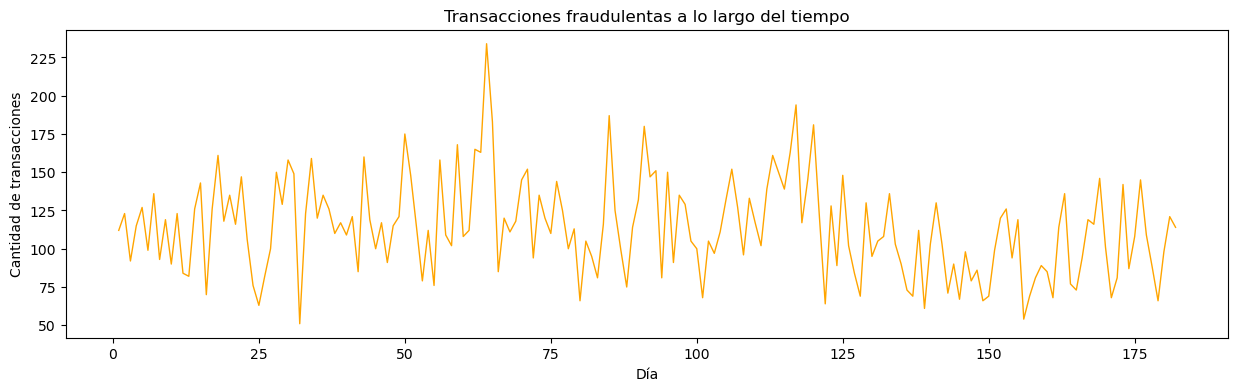

In [30]:
plt.figure(figsize=(15, 4))
fraud_df[fraud_df['isfraud'] == 1].groupby('transaction_day').size().plot(kind='line', color='orange', lw=1)
plt.title('Transacciones fraudulentas a lo largo del tiempo')
plt.xlabel('Día')
plt.ylabel('Cantidad de transacciones')

plt.show()

Si nos centramos exclusivamente en las fraudulentas, no se aprecía tanto ese incremento en el período navideño. El máximo se alcanza aproximadamente en los 60 días. Por otra parte, sí se aprecía una disminución en los últimos días.

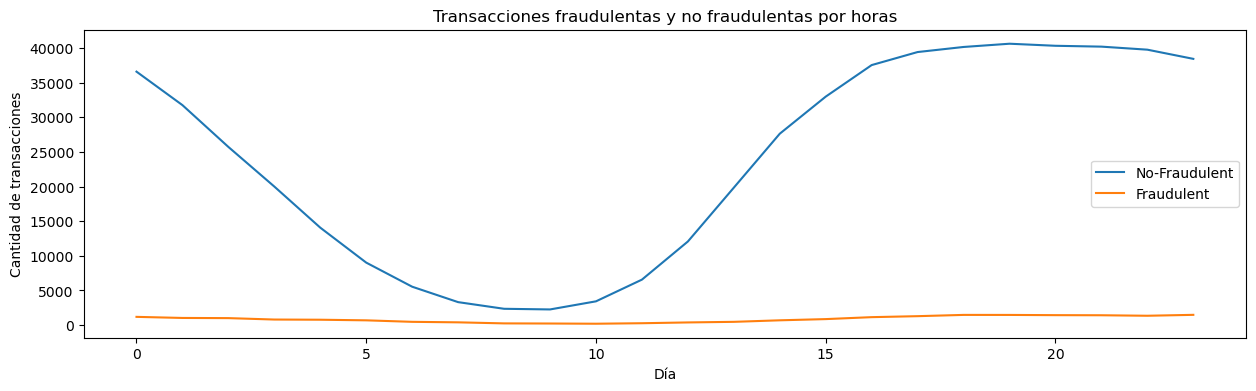

In [31]:
fraud_df.groupby(['isfraud', 'transaction_hour']).size().unstack(level=0).plot(kind='line', figsize=(15, 4))
plt.title('Transacciones fraudulentas y no fraudulentas por horas')
plt.xlabel('Día')
plt.ylabel('Cantidad de transacciones')
plt.legend(['No-Fraudulent', 'Fraudulent'])

plt.show()

La mayor parte de las transacciones se realizan por la tarde, a partir de las 20:00 las no fraudulentas comienzan a disminuir hasta la mañana.

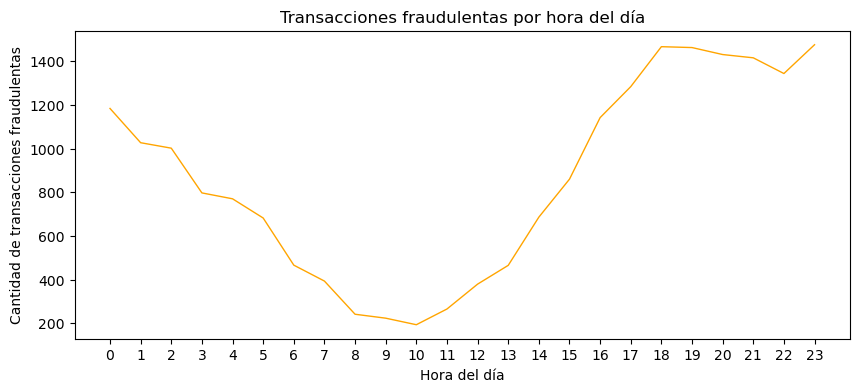

In [32]:
plt.figure(figsize=(10, 4))
fraud_df[fraud_df['isfraud'] == 1].groupby(fraud_df['transaction_hour']).size().plot(kind='line', color='orange', lw=1, title='Transacciones fraudulentas por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de transacciones fraudulentas')
plt.xticks(np.arange(0, 24))
plt.savefig('fraude_hora.jpg')

plt.show()

Analizando las fraudulentas se aprecía un comportamiento muy similar pero, a partir de las 20 - 21 se aprecia un aumento, los estafadores aprovechan las horas en las que las victimas duermen para realizar los cargos.

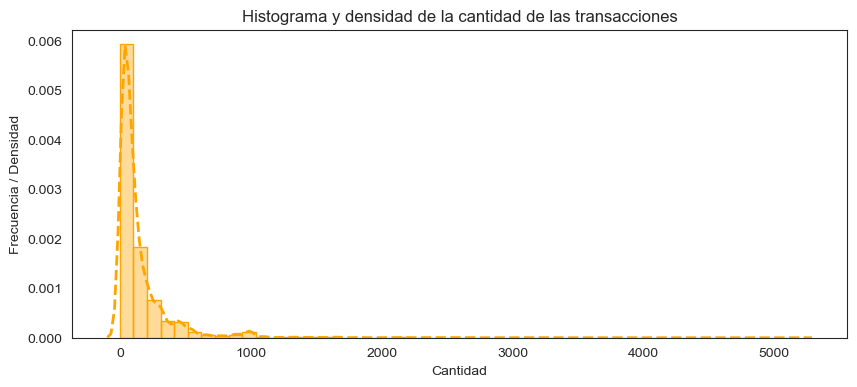

In [33]:
# Representation of the frequency and density of the amount of the transaction
sns.set_style("white")
plt.figure(figsize=(10, 4))
sns.histplot(data=fraud_df[fraud_df['isfraud'] == 1], x='transactionamt', bins=50, kde=False, edgecolor='orange', color='orange', alpha=0.4, stat='density')
sns.kdeplot(data=fraud_df[fraud_df['isfraud'] == 1], x='transactionamt', color='orange', lw=2, linestyle='--')
plt.title('Histograma y densidad de la cantidad de las transacciones')
plt.xlabel('Cantidad')
plt.ylabel('Frecuencia / Densidad')
plt.savefig('fraude_densidad_valor.jpg')

plt.show()

La mayoría de las transacciones fraudulentas son de importes bajos, ya que principalmente se concentran en todo a los 100 - 200 dólares y a partir de los 1000 la frecuencia comienza a ser muy baja. 

Esto se debe a que los estafadores suelen comenzar a hacer transacciones de cantidades pequeñas para verificar el funcionamiento de la tarjeta y posteriormente van incrementando. Además de que en ocasiones, es necesario que el propio cliente confirme la compra si es superior a cierta cantidad, lo que limita las cuantías que pueden robar. La detección temprana de estas actividades por parte de las víctimas también ayuda a una menor cantidad de transacciones fraudulentas con cuantías elevadas, como se puede ver en la visualización. 

Este hecho resalta la importancia de un control constante de las cuentas, lo cual permitirá a las víctimas reaccionar rápido, proteger sus cuentas y prevenir pérdidas adicionales.

### 6.1. Outliers

In [34]:
# I create a list with all the numeric variables.
var_num = [
    'transactiondt', 'transactionamt', 'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10', 'c11','c12',
    'c13','c14','d1','d2','d3','d4','d10','d11','d15', 'v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13',
    'v15', 'v16','v17','v18','v19','v20','v21','v22','v23','v24','v25','v26','v29', 'v30','v31','v32','v33','v34',
    'v35','v36','v37','v38','v39','v40','v42','v43','v44','v45','v46','v47', 'v48','v49','v50','v51','v52','v53',
    'v54','v55','v56','v57','v58','v59','v60','v61','v62','v63','v64','v66', 'v67', 'v69','v70', 'v71','v72','v73',
    'v74','v75', 'v76','v77','v78','v79','v80','v81','v82','v83','v84','v85', 'v86','v87','v90', 'v91','v92','v93',
    'v94','v98','v99','v100','v104','v105','v106','v108','v109', 'v110','v111','v112','v113','v114','v115','v116',
    'v117','v118','v119','v120','v121','v122','v123','v124', 'v125','v126','v127','v128','v129','v130','v131','v132',
    'v133','v134','v135','v136','v137', 'v279','v280','v281', 'v282','v283','v284','v285','v286','v287','v288','v289', 
    'v290','v291','v292','v293','v294','v295','v296','v297', 'v298','v299','v300', 'v301','v302','v303','v304','v306',
    'v307','v308','v309','v310', 'v311','v312','v313','v314', 'v315','v316','v317','v318','v319','v320','v321'
]

# I use the function 'get_deviation_of_mean_perc' that I have imported to calculate the outliers.
get_deviation_of_mean_perc(fraud_df, var_num, target='isfraud', multiplier=1.5)

0.0       1.0 variable  sum_outlier_values  \
0    0.920688  0.079312     v302              140294   
1    0.963370  0.036630      v62              114906   
2    0.970584  0.029416      v20              112522   
3    0.967895  0.032105      v61              109237   
4    0.971485  0.028515      v19              108786   
..        ...       ...      ...                 ...   
180  0.893849  0.106151     v120                1008   
181  0.786437  0.213563     v118                 988   
182  0.733247  0.266753     v119                 776   
183  0.720770  0.279230     v117                 727   
184  0.814371  0.185629     v291                 334   

     porcentaje_sum_outlier_values  
0                         0.237596  
1                         0.194600  
2                         0.190563  
3                         0.184999  
4                         0.184236  
..                             ...  
180                       0.001707  
181                       0.001673  
182                       0.001314  
183                       0.001231  
184                       0.000566  

[186 rows x 5 columns]

A continuación, voy a realizar un análisis exploratorio de las variables que tienen más de un 15% de outliers para analizarlos correctamente y decidir como tratarlos.

#### v302

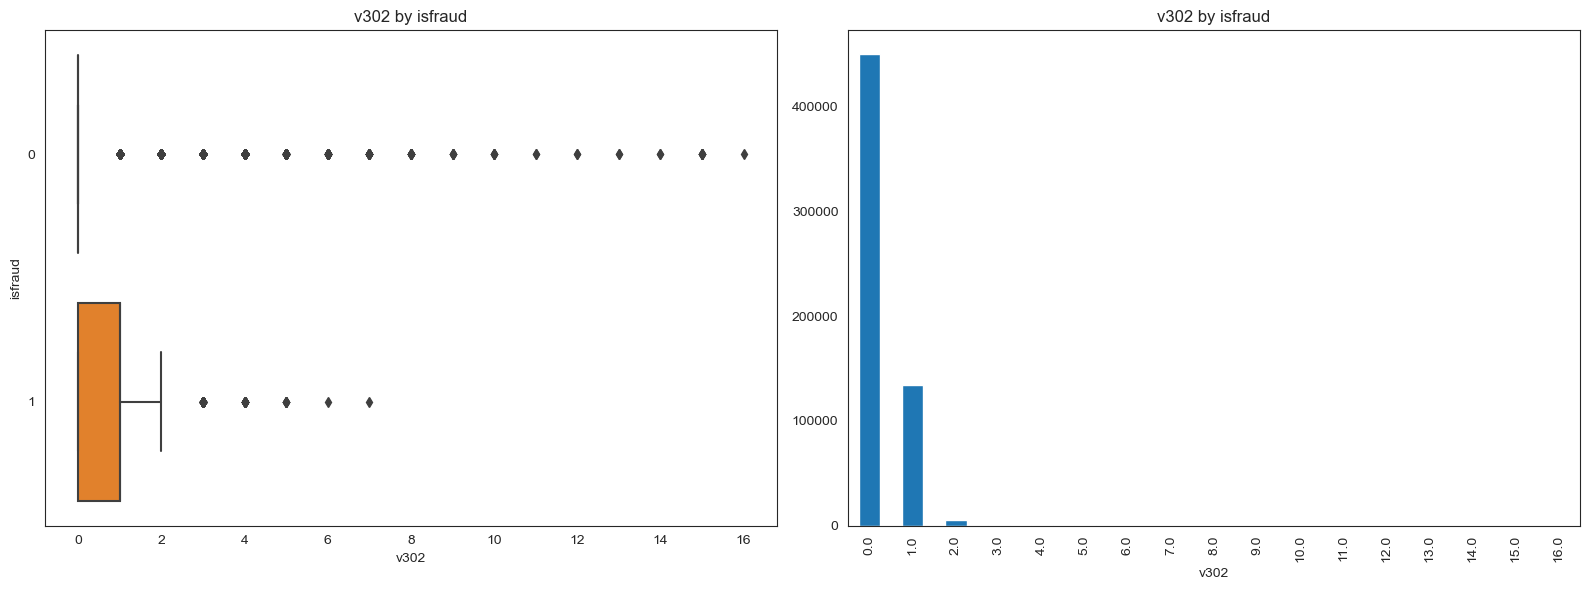

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v302', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v302 by isfraud')

fraud_df.groupby(('v302'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v302 by isfraud")

plt.tight_layout()
plt.show()

#### v62

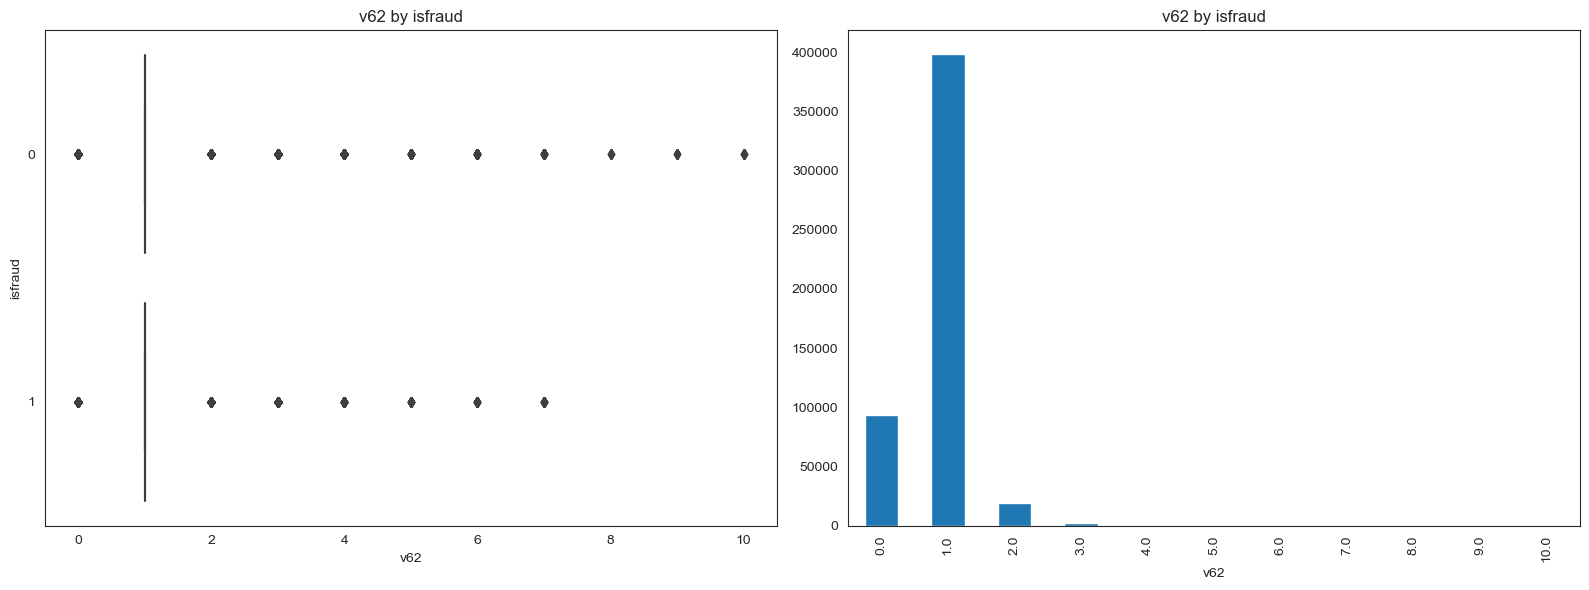

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v62', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v62 by isfraud')

fraud_df.groupby(('v62'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v62 by isfraud")

plt.tight_layout()
plt.show()

#### v20

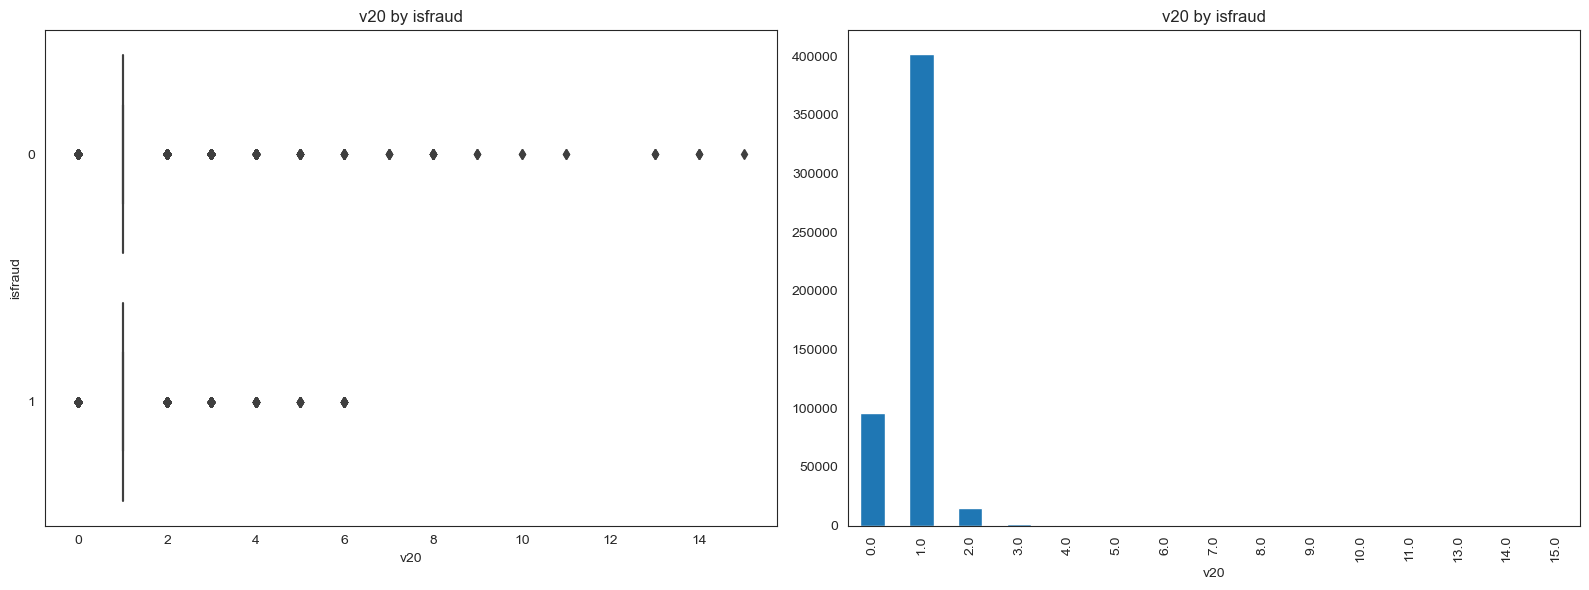

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v20', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v20 by isfraud')

fraud_df.groupby(('v20'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v20 by isfraud")

plt.tight_layout()
plt.show()

#### v61

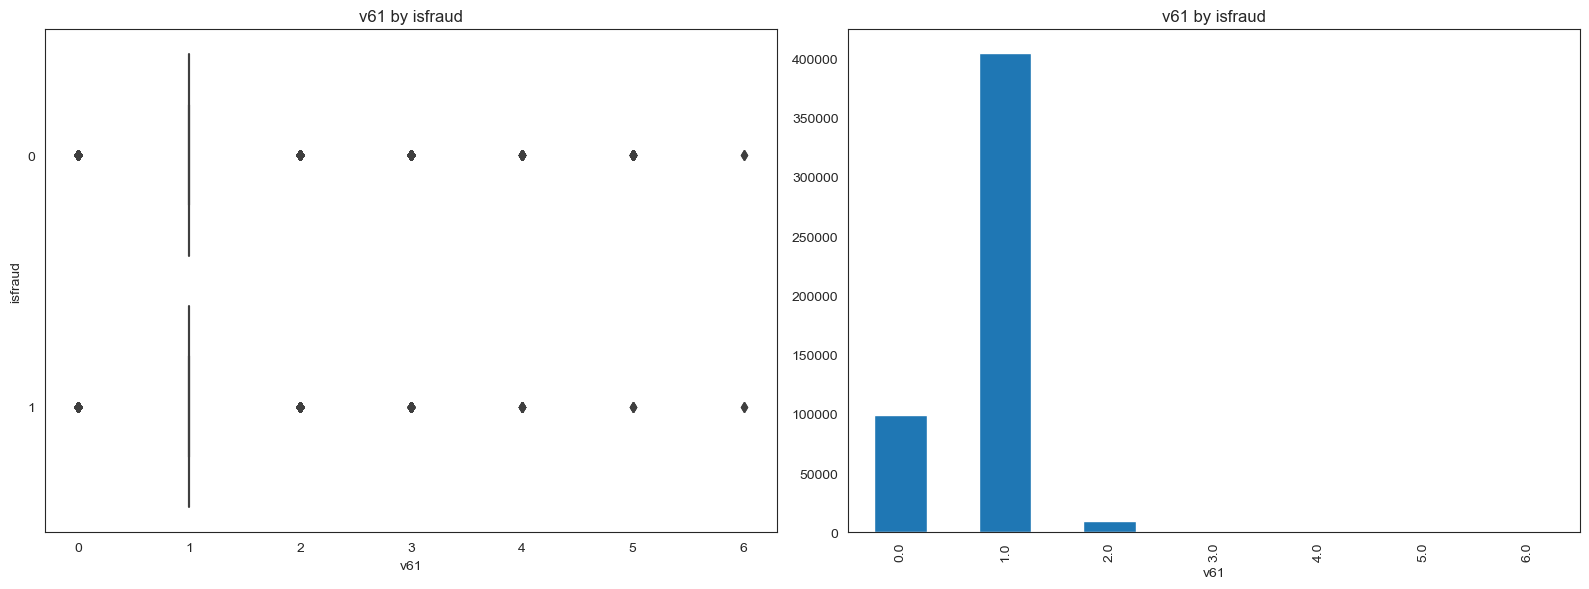

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v61', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v61 by isfraud')

fraud_df.groupby(('v61'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v61 by isfraud")

plt.tight_layout()
plt.show()

#### v19

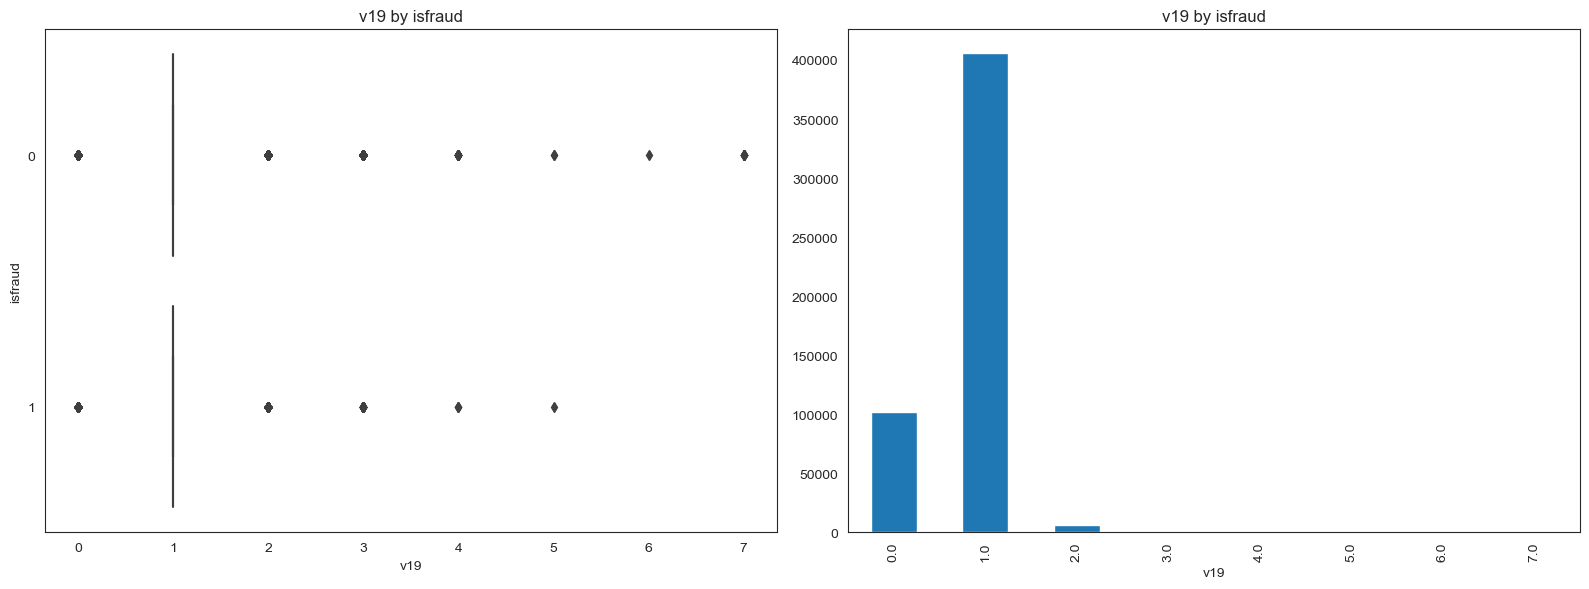

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v19', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v19 by isfraud')

fraud_df.groupby(('v19'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v19 by isfraud")

plt.tight_layout()
plt.show()

#### v83

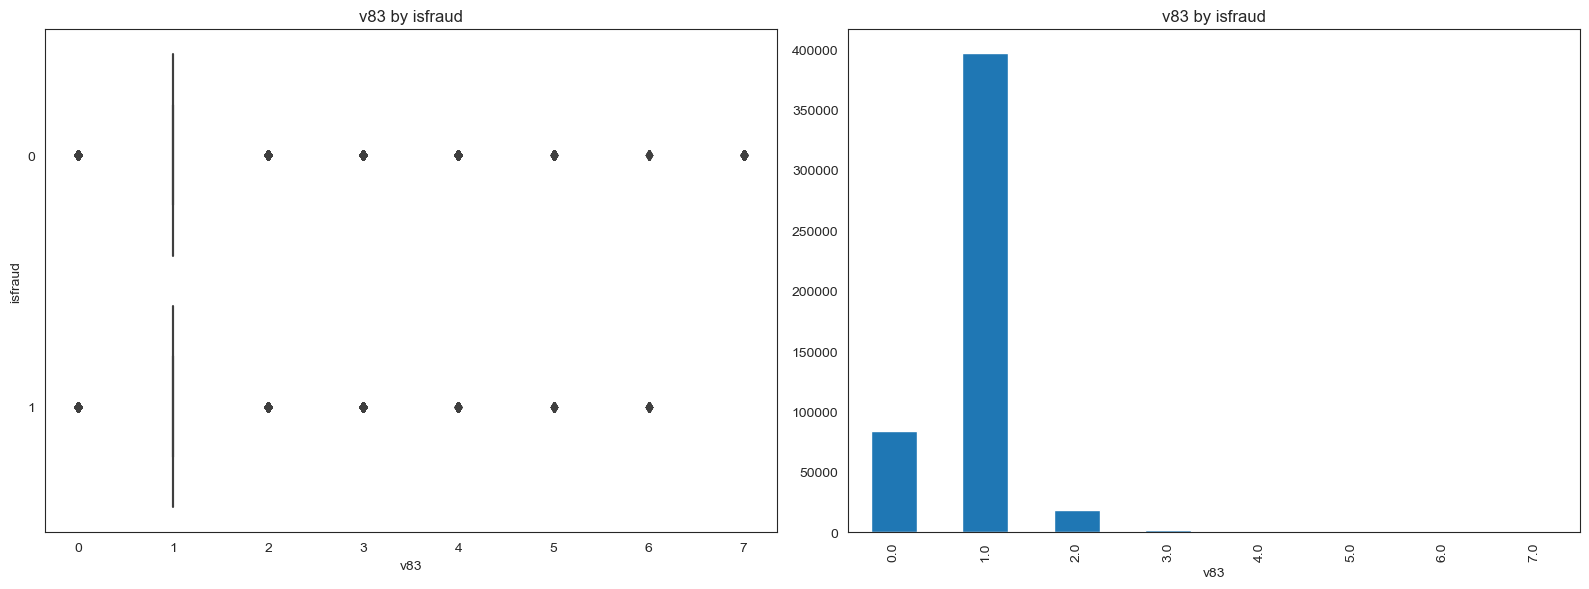

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v83', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v83 by isfraud')

fraud_df.groupby(('v83'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v83 by isfraud")

plt.tight_layout()
plt.show()

#### v288

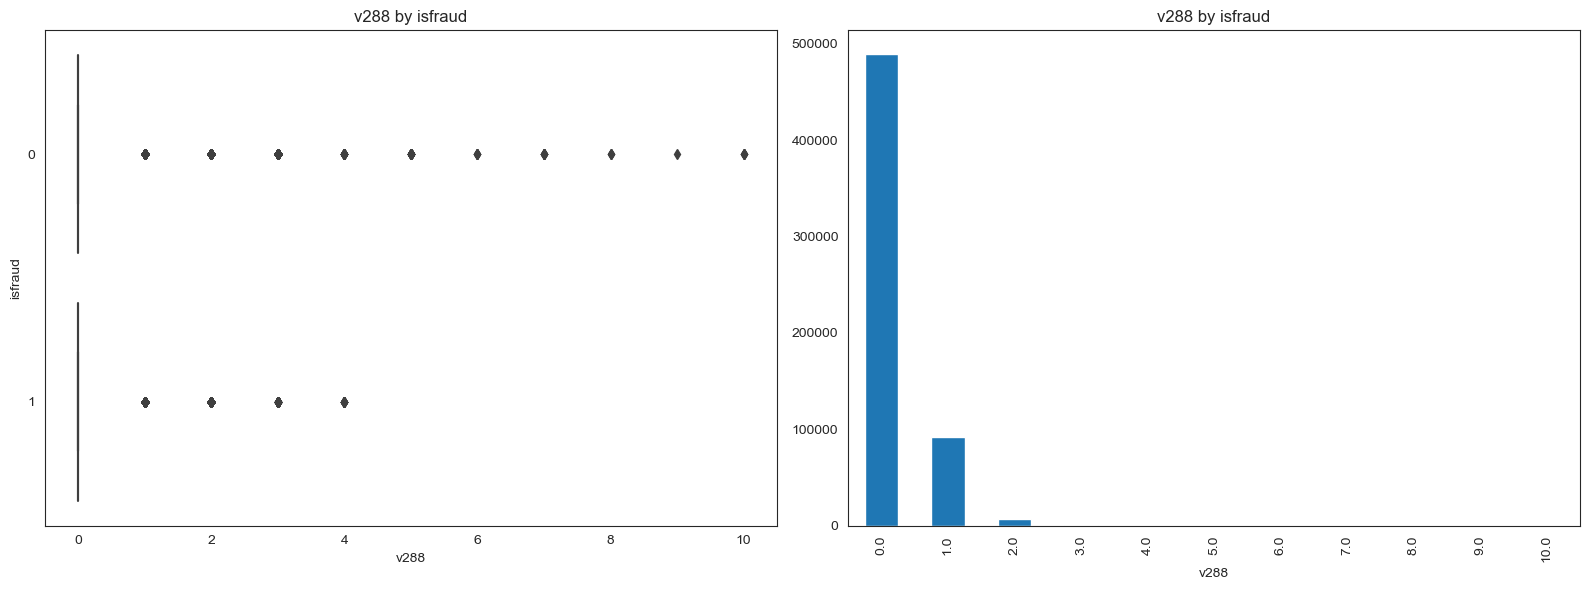

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v288', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v288 by isfraud')

fraud_df.groupby(('v288'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v288 by isfraud")

plt.tight_layout()
plt.show()

#### v82

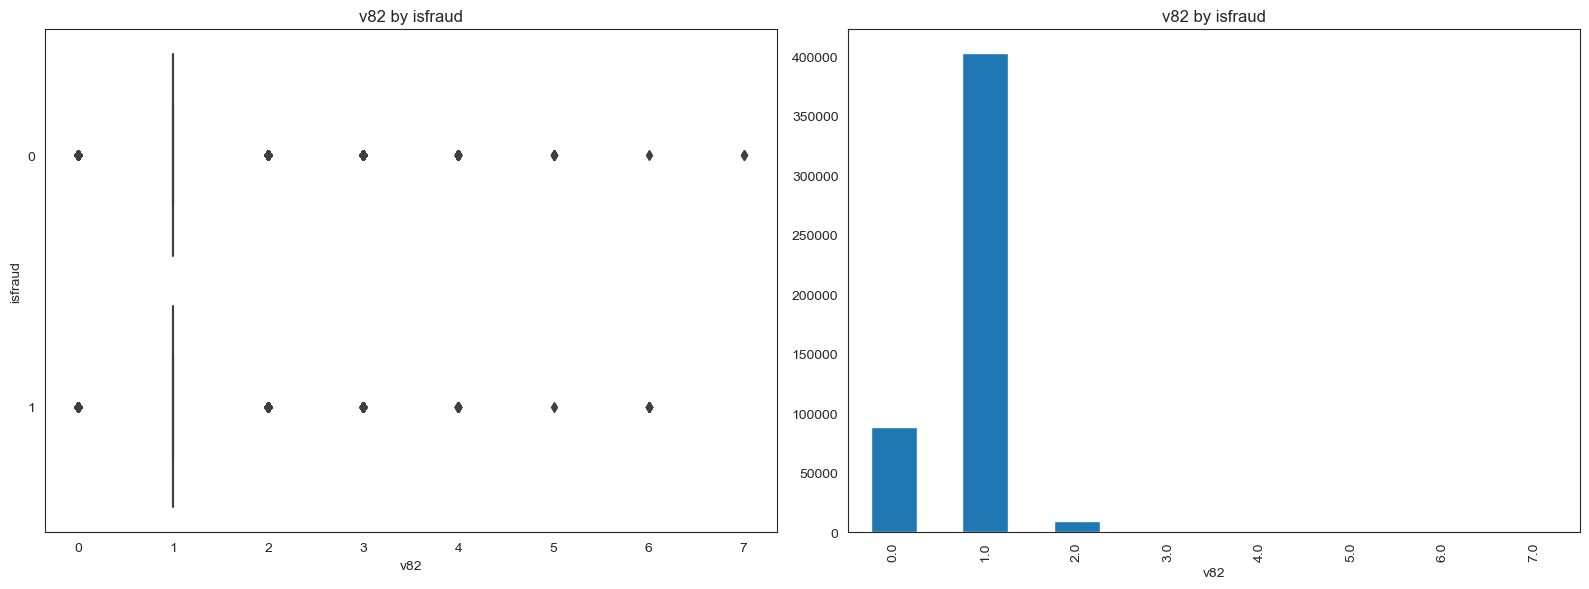

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='v82', y='isfraud', data=fraud_df, orient='h', ax=axs[0])
axs[0].set_title('v82 by isfraud')

fraud_df.groupby(('v82'))['isfraud'].count().plot(kind="bar", ax=axs[1])
axs[1].set_title("v82 by isfraud")

plt.tight_layout()
plt.show()

Tras analizar los boxplot y las frecuencias de estas variables y dado que no se conoce significado concreto de cada una, se ha decidido eliminar a partir del outlier que la frecuencia comienza a ser demasiado baja, ya que podrían ser datos erróneos.

In [43]:
fraud_df = fraud_df.loc[(fraud_df['v302'] <= 4) | (fraud_df['v302'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v62'] <= 4) | (fraud_df['v62'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v20'] <= 4) | (fraud_df['v20'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v61'] <= 3) | (fraud_df['v61'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v19'] <= 3) | (fraud_df['v19'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v83'] <= 4) | (fraud_df['v83'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v288'] <= 3) | (fraud_df['v288'].isna())]
fraud_df = fraud_df.loc[(fraud_df['v82'] <= 3) | (fraud_df['v82'].isna())]

### 6.2. Correlación de Pearson

A continuación voy a realizar la **correlación de Pearson para descartar variables que tengan una alta relación**, en caso de que existan. 

Como son demasiadas variables numéricas y antes ya se ha hablado de su significado, se van a calcular las correlaciones por grupos de nombres por separado, ya que son las que es más probable que tengan relación y así se puede analizaar más detalladamente. 

Por otra parte, en el caso de las columnas *v* se realizará por grupos de 50, dado que son demasiadas columnas y no se visualizaría correctamente.

#### c1 - c14

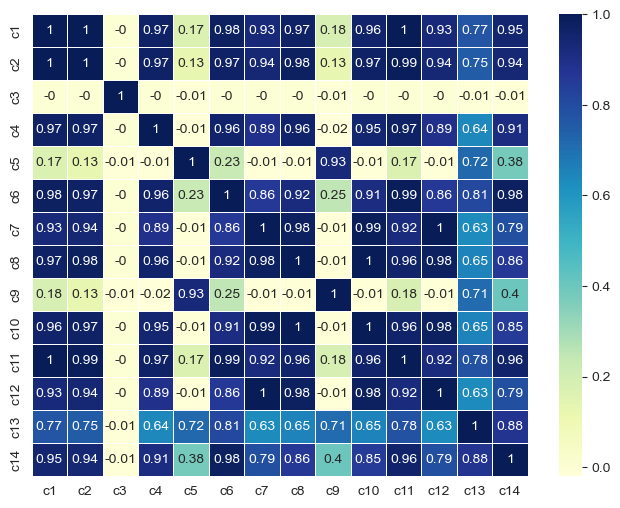

In [44]:
correlacion_c = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14']
plt.figure(figsize=(8,6))
sns.heatmap(round(fraud_df[correlacion_c].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [45]:
# I use reduce_group function that I have created to decided the columns to maintain.
grps = [[1,2,4,6,7,8,10,11,12,13,14],[3],[5,9]]    
reduce_group(grps, c='c')

# I drop c2, c4, c6, c7, c8, c9, c10, c11, c12, c13, c14 column.
fraud_df = fraud_df.drop(['c2', 'c4', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14'], axis=1)

Las columnas a mantener son: [1, 3, 5]


#### d1 - d15

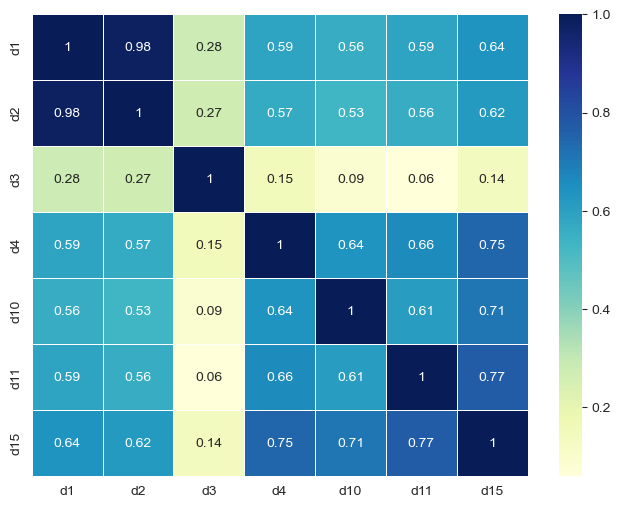

In [46]:
correlacion_d = ['d1', 'd2', 'd3', 'd4', 'd10', 'd11', 'd15']

plt.figure(figsize=(8,6))
sns.heatmap(round(fraud_df[correlacion_d].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

La correlación más alta se da entre *d1 - d2*, **se va a mantener *d1* y eliminar *d2***. Tras revisar sus valores son practicamente iguales, pero cuando hay valores 0 en d1, son sustituidos por nulos en d2.

In [47]:
# I drop d2 column.
fraud_df = fraud_df.drop('d2', axis=1)

#### vx

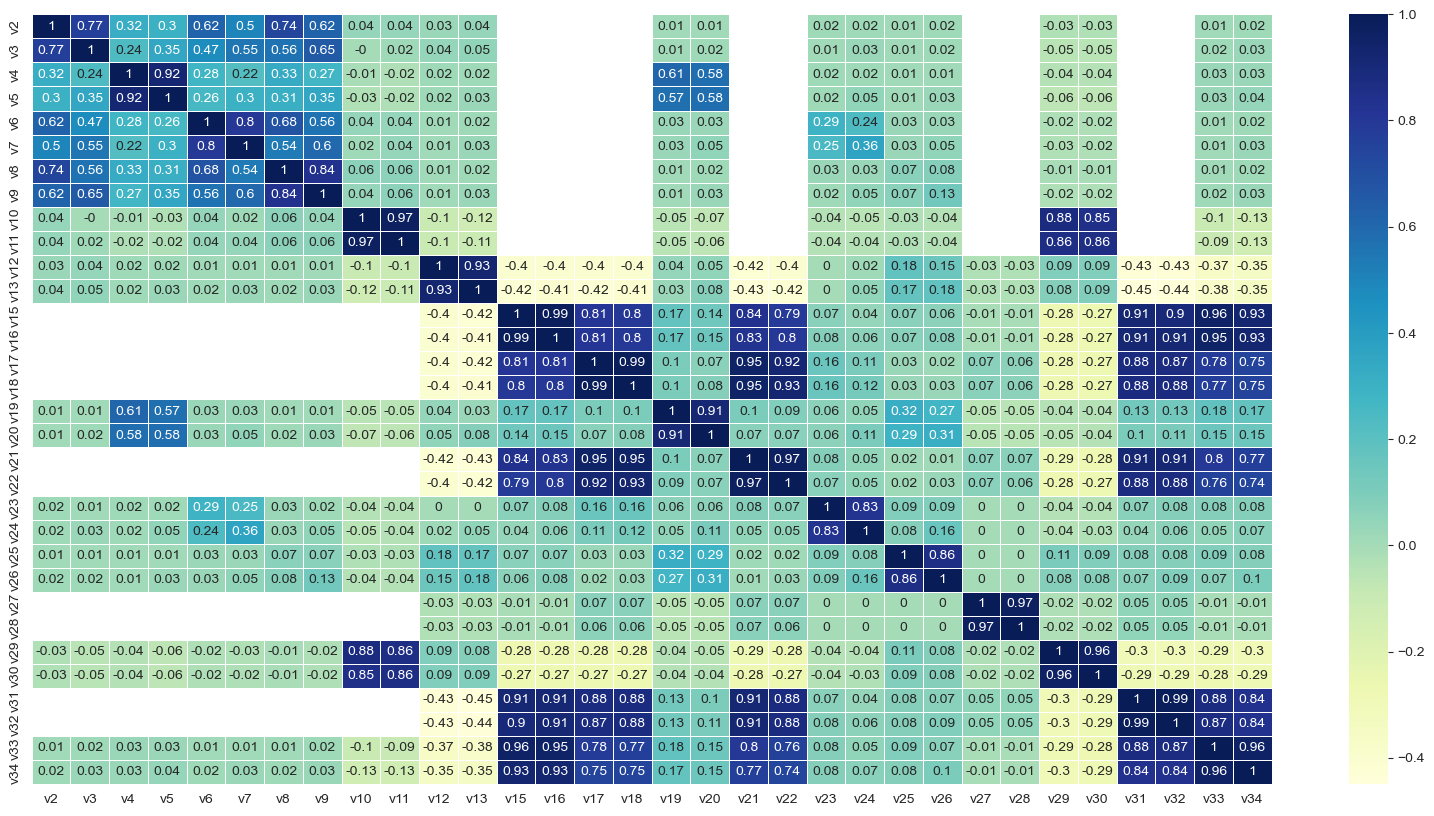

In [48]:
correlacion_v1 = [
    'v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v15','v16','v17','v18','v19','v20','v21','v22',
    'v23','v24','v25','v26','v27','v28','v29','v30','v31','v32','v33','v34'
]
plt.figure(figsize=(20,10))
sns.heatmap(round(fraud_df[correlacion_v1].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [49]:
grps = [
    [2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[15,16,17,18,21,22,31,32,33,34],[19,20],[23,24],[25,26],[27,28],
        [29,30]
] 

reduce_group(grps)

Las columnas a mantener son: [3, 4, 6, 8, 11, 13, 17, 20, 23, 26, 27, 30]


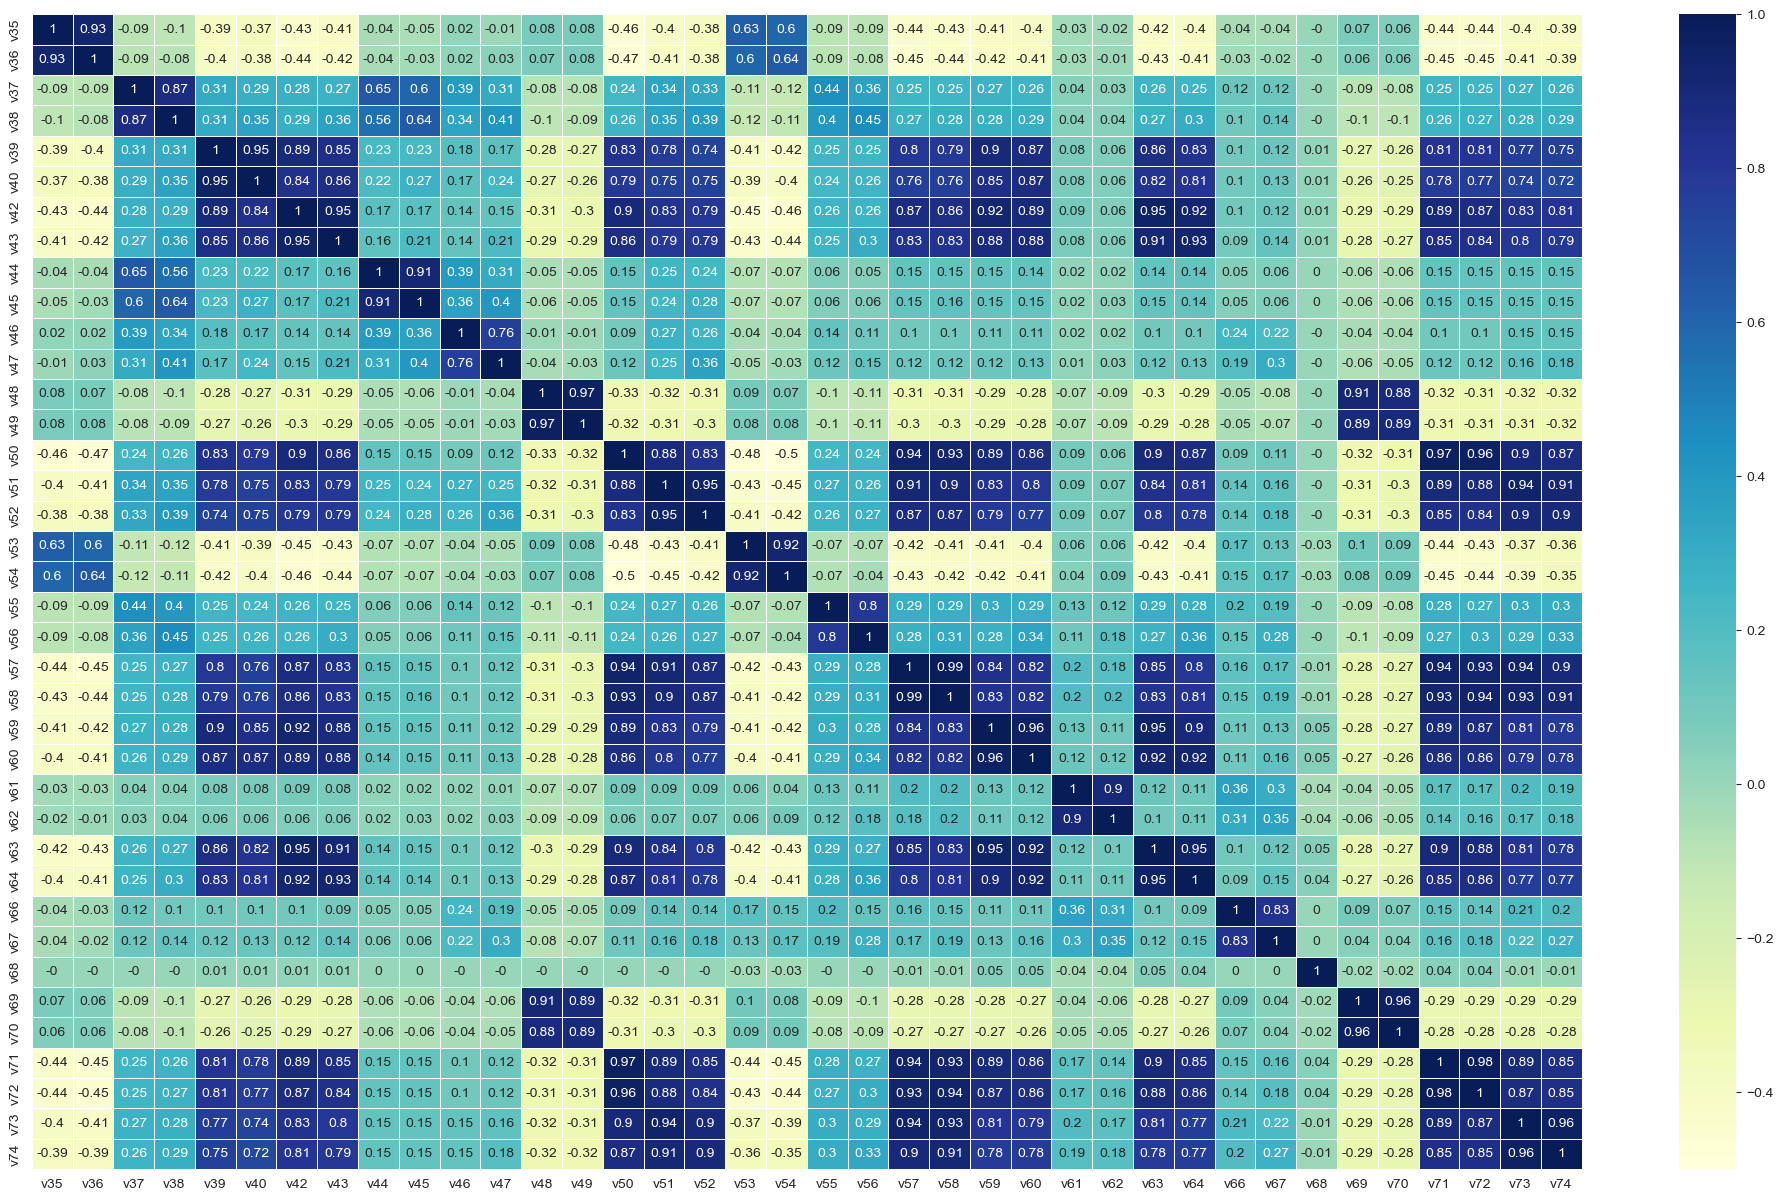

In [50]:
correlacion_v2 = [
    'v35','v36','v37','v38','v39','v40','v42','v43','v44','v45','v46','v47','v48','v49','v50','v51','v52','v53','v54',
    'v55','v56','v57','v58','v59','v60', 'v61','v62','v63','v64','v66', 'v67', 'v68', 'v69','v70', 'v71','v72','v73',
    'v74'
]
plt.figure(figsize=(25,15))
sns.heatmap(round(fraud_df[correlacion_v2].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [51]:
grps = [[35,36],[37,38],[39,40,42,43,50,51,52,57,58,59,60,63,64,71,72,73,74],[44,45],[46,47],[48,49],[53,54],[55,56],
        [61,62],[66,67],[68],[69,70]]    
reduce_group(grps)

Las columnas a mantener son: [36, 37, 40, 44, 47, 48, 54, 56, 62, 67, 68, 70]


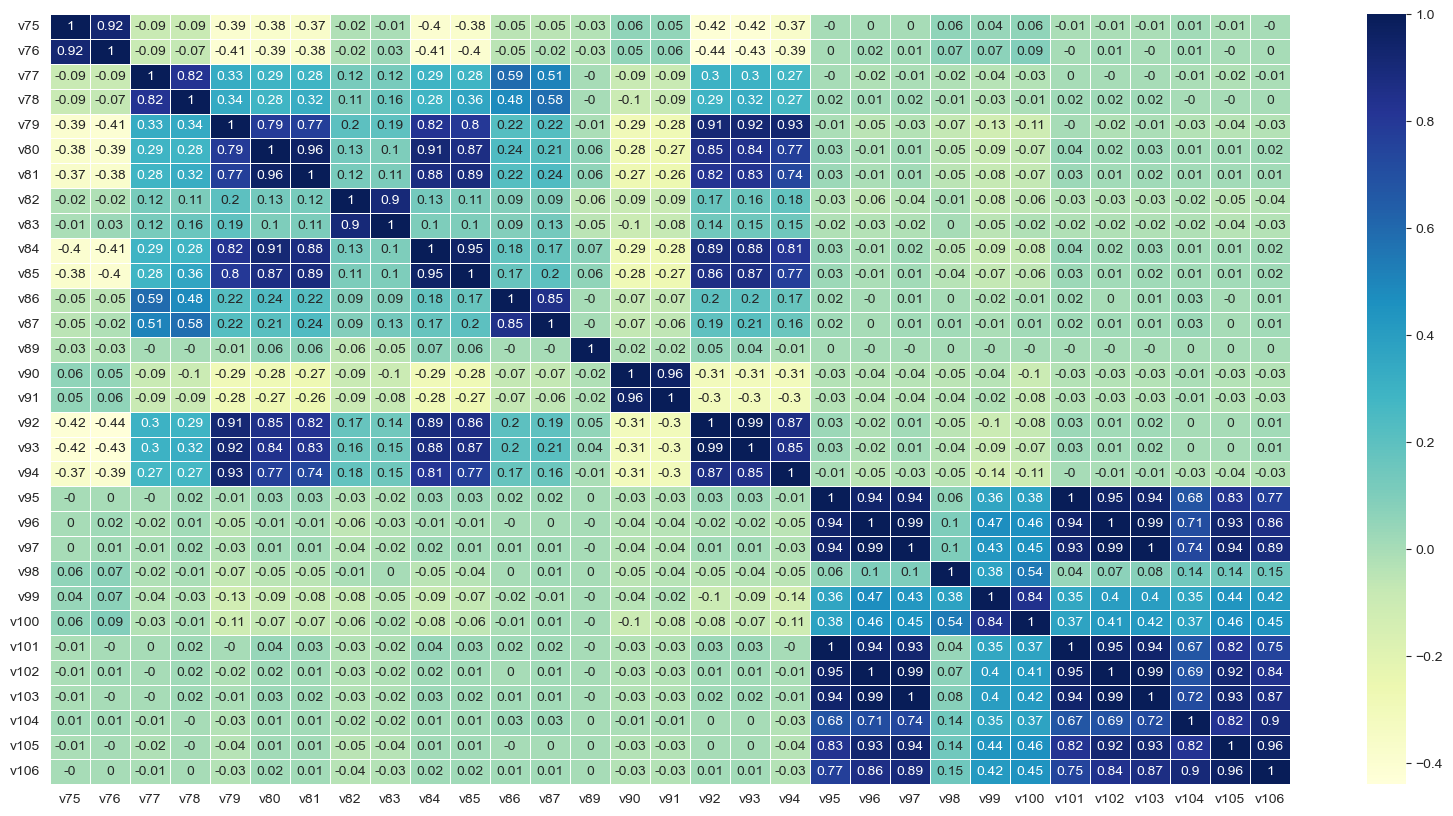

In [52]:
correlacion_v3 = [
    'v75', 'v76','v77','v78','v79','v80','v81','v82','v83','v84','v85', 'v86','v87', 'v89', 'v90', 'v91','v92','v93', 
    'v94', 'v95', 'v96', 'v97', 'v98','v99','v100', 'v101', 'v102', 'v103', 'v104','v105','v106'
]
plt.figure(figsize=(20,10))
sns.heatmap(round(fraud_df[correlacion_v3].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [53]:
grps = [[75,76],[77,78],[79,80,81,84,85,92,93,94],[82,83],[86,87],[89],[90,91],[95,96,97,101,102,103,105,106],[98],
        [99,100],[104]] 
reduce_group(grps)

Las columnas a mantener son: [76, 78, 80, 83, 86, 89, 91, 96, 98, 99, 104]


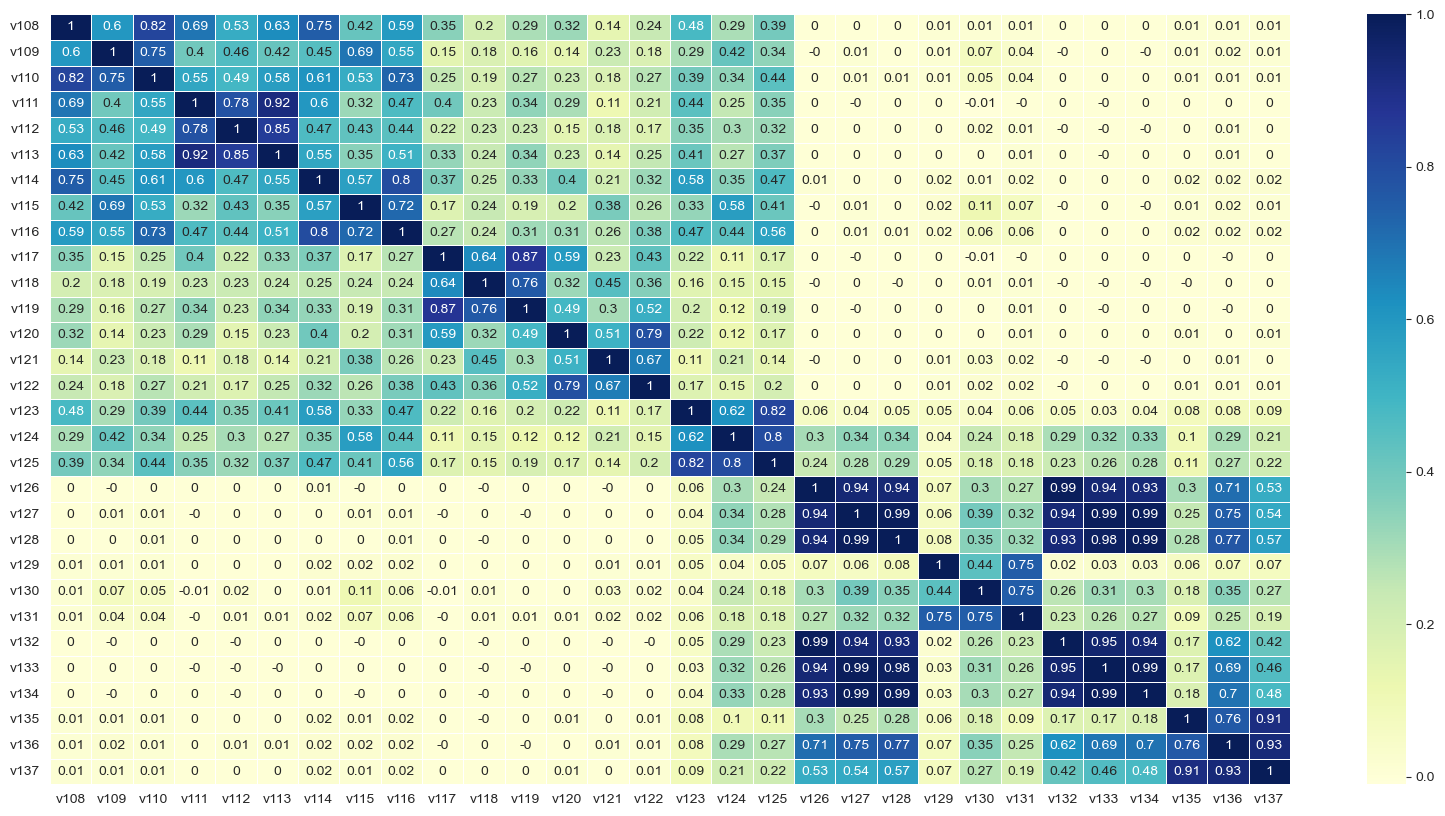

In [54]:
correlacion_v4 = [
    'v108','v109', 'v110','v111','v112','v113','v114','v115','v116','v117','v118','v119','v120','v121','v122','v123',
    'v124', 'v125','v126','v127','v128','v129','v130','v131','v132','v133','v134','v135','v136','v137'
]
plt.figure(figsize=(20,10))
sns.heatmap(round(fraud_df[correlacion_v4].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [55]:
grps = [[108,109,110,114],[111,112,113],[115,116],[117,118,119],[120,122],[121],[123,125],[124],
       [126,127,128,132,133,134],[129],[130,131],[135,136,137]] 
reduce_group(grps)

Las columnas a mantener son: [108, 111, 115, 117, 120, 121, 123, 124, 127, 129, 130, 136]


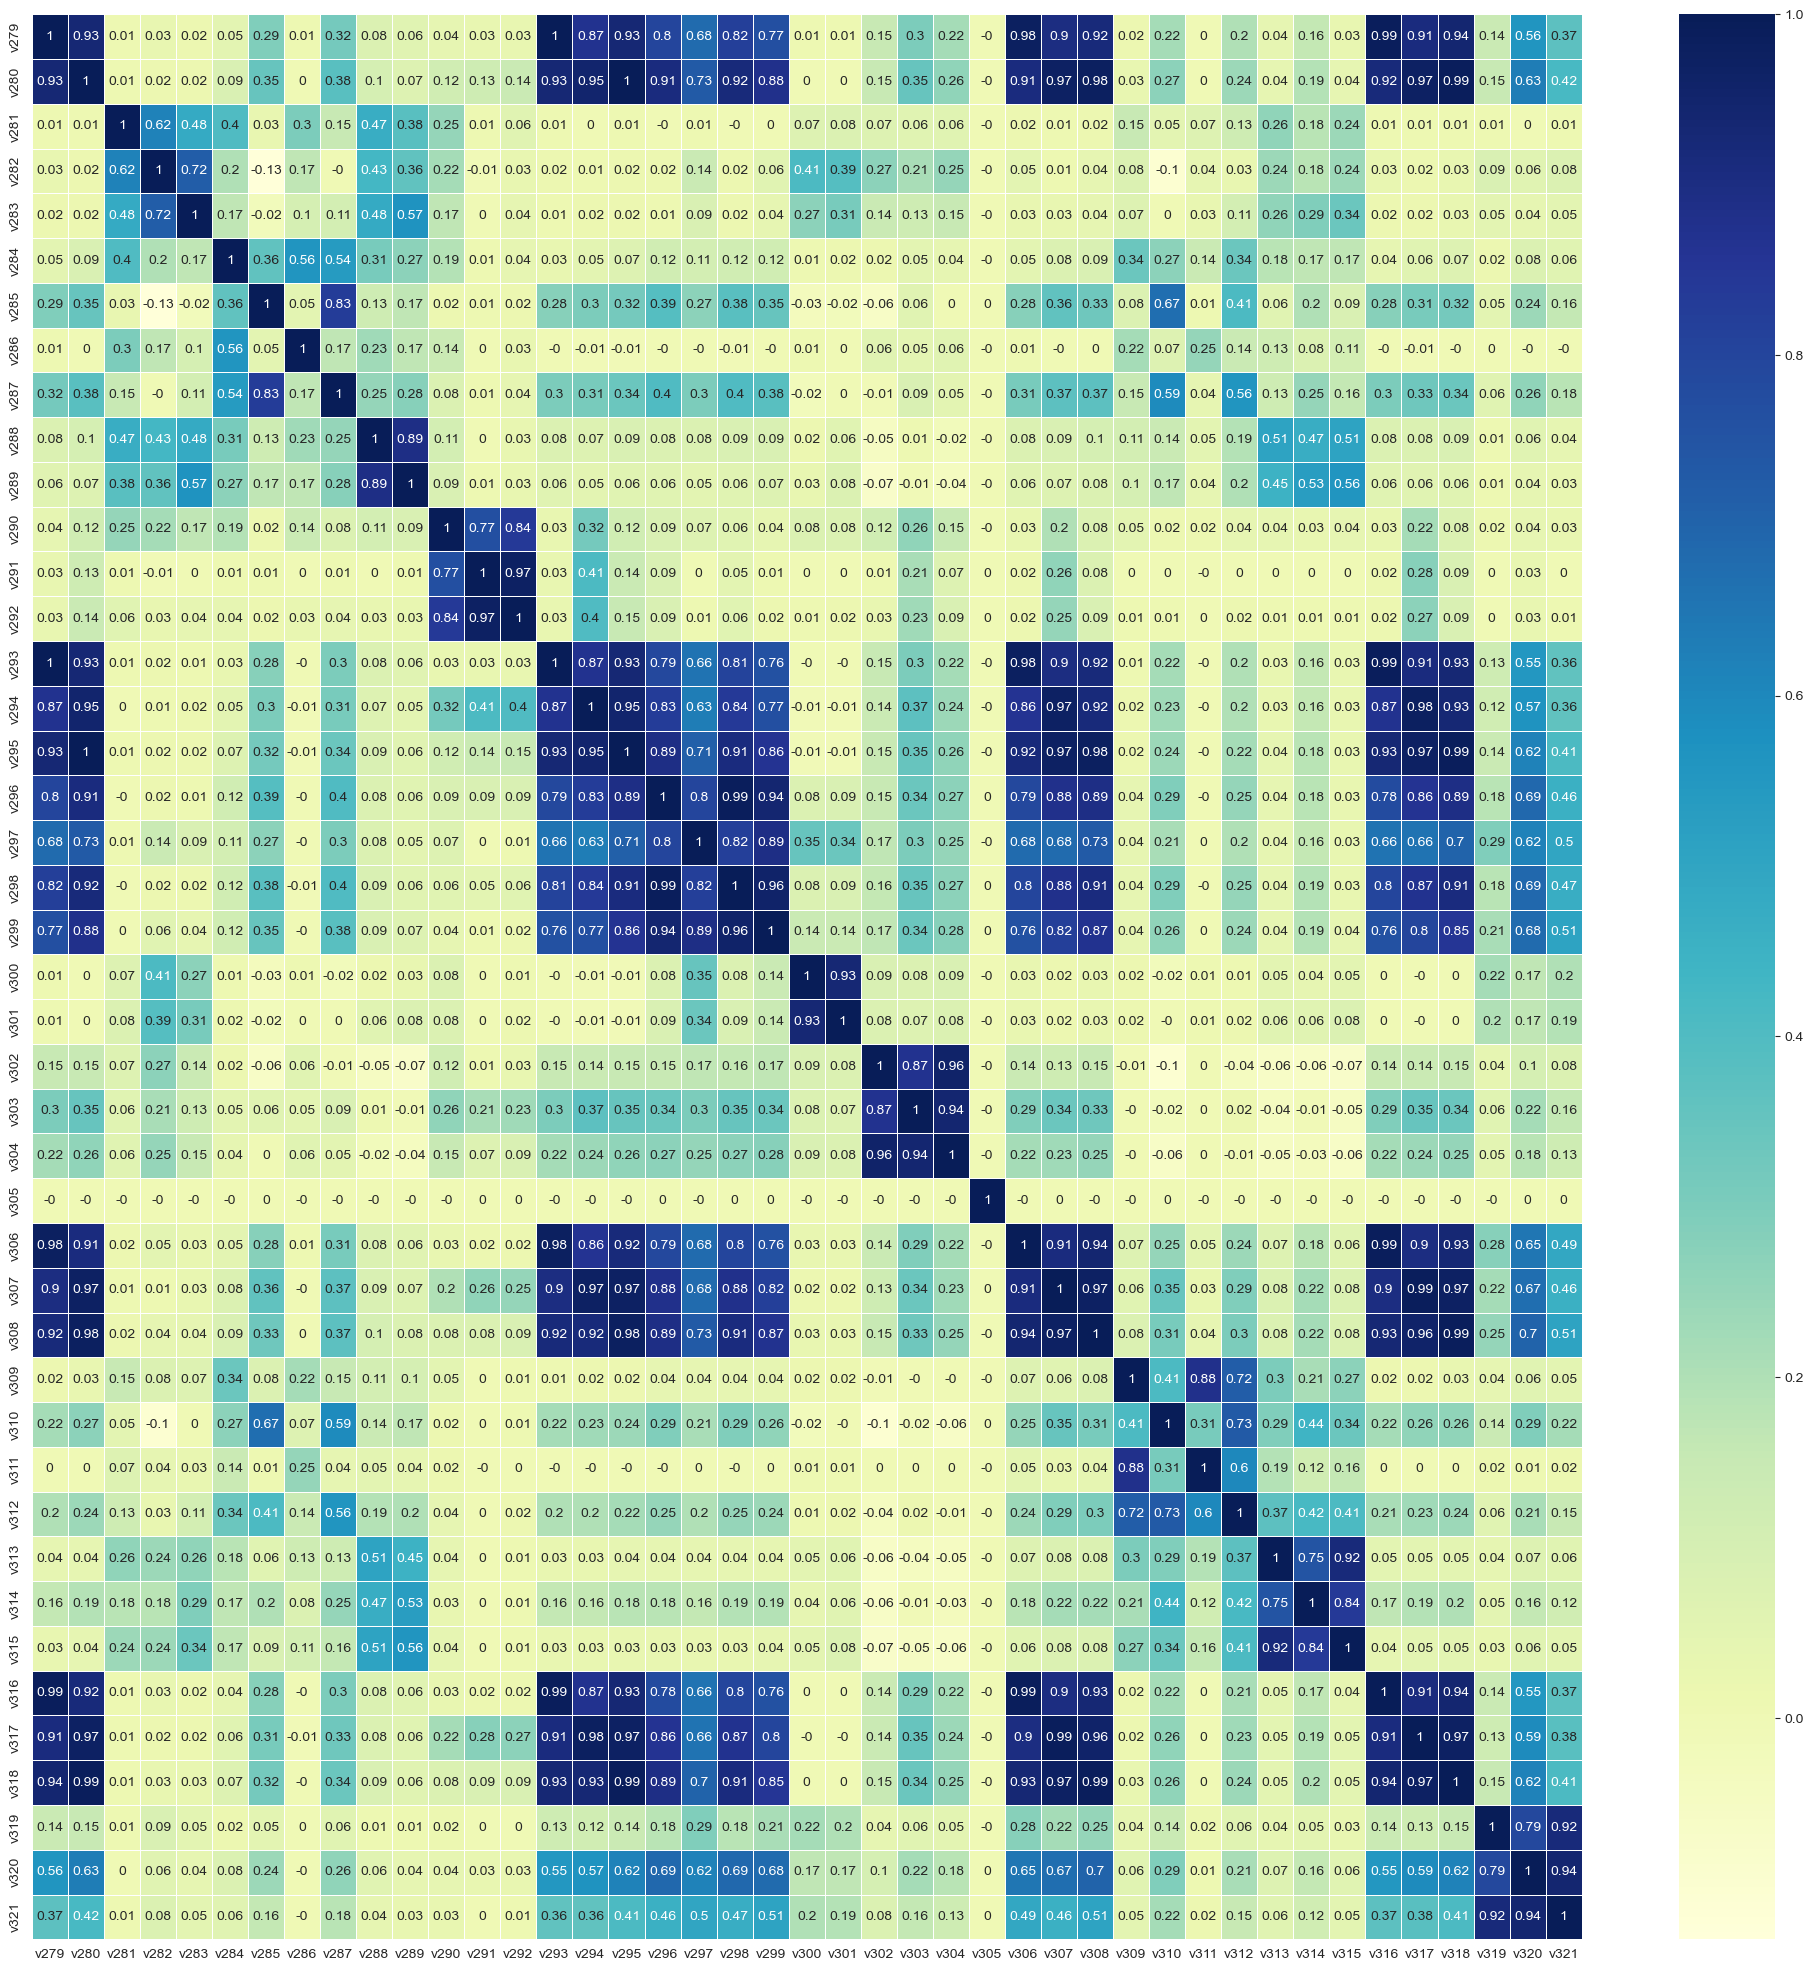

In [56]:
correlacion_v5 = [
    'v279','v280','v281', 'v282','v283','v284','v285','v286','v287','v288','v289','v290','v291','v292','v293','v294',
    'v295','v296','v297', 'v298','v299','v300', 'v301','v302','v303','v304','v305', 'v306','v307','v308','v309','v310',
    'v311','v312','v313','v314', 'v315','v316','v317','v318','v319','v320','v321'
]
plt.figure(figsize=(25,25))
sns.heatmap(round(fraud_df[correlacion_v5].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

In [57]:
grps = [[279,280,293,294,295,296,298,299],[281],[282,283],[284],[285,287],[286],[288,289],[290,291,292],[297],
       [300,301],[302,303,304],[305],[306,307,308,316,317,318],[309,311],[310,312],[313,314,315],[319,320,321]] 
reduce_group(grps)

Las columnas a mantener son: [294, 281, 283, 284, 285, 286, 289, 291, 297, 301, 303, 305, 307, 309, 310, 314, 320]


In [58]:
v_to_drop = [
    'v2', 'v5', 'v7', 'v9', 'v10', 'v12', 'v15', 'v16', 'v18', 'v19', 'v21', 'v22', 'v24', 'v25', 'v28', 'v29',
    'v31', 'v32', 'v33', 'v34', 'v35', 'v38', 'v39', 'v42','v43', 'v45','v46', 'v49','v50','v51','v52','v53', 
    'v55', 'v57','v58','v59','v60', 'v61', 'v63','v64','v66', 'v69', 'v71','v72', 'v73','v74', 
    'v75', 'v77', 'v79', 'v81', 'v82','v84','v85','v87', 'v90', 'v92','v93', 'v94', 'v95', 'v97', 'v100','v101', 
    'v102', 'v103', 'v105','v106','v109', 'v110','v112','v113','v114', 'v116', 'v118','v119', 'v122', 'v125','v126', 
    'v128', 'v131','v132','v133','v134','v135','v137', 'v279','v280', 'v282', 'v287','v288', 'v290', 'v292','v293',
    'v295','v296','v298','v299','v300', 'v302', 'v304','v306', 'v308', 'v311', 'v312','v313', 'v315','v316','v317',
    'v318','v319', 'v321'
]

# I drop v columns.
fraud_df = fraud_df.drop(v_to_drop, axis=1)

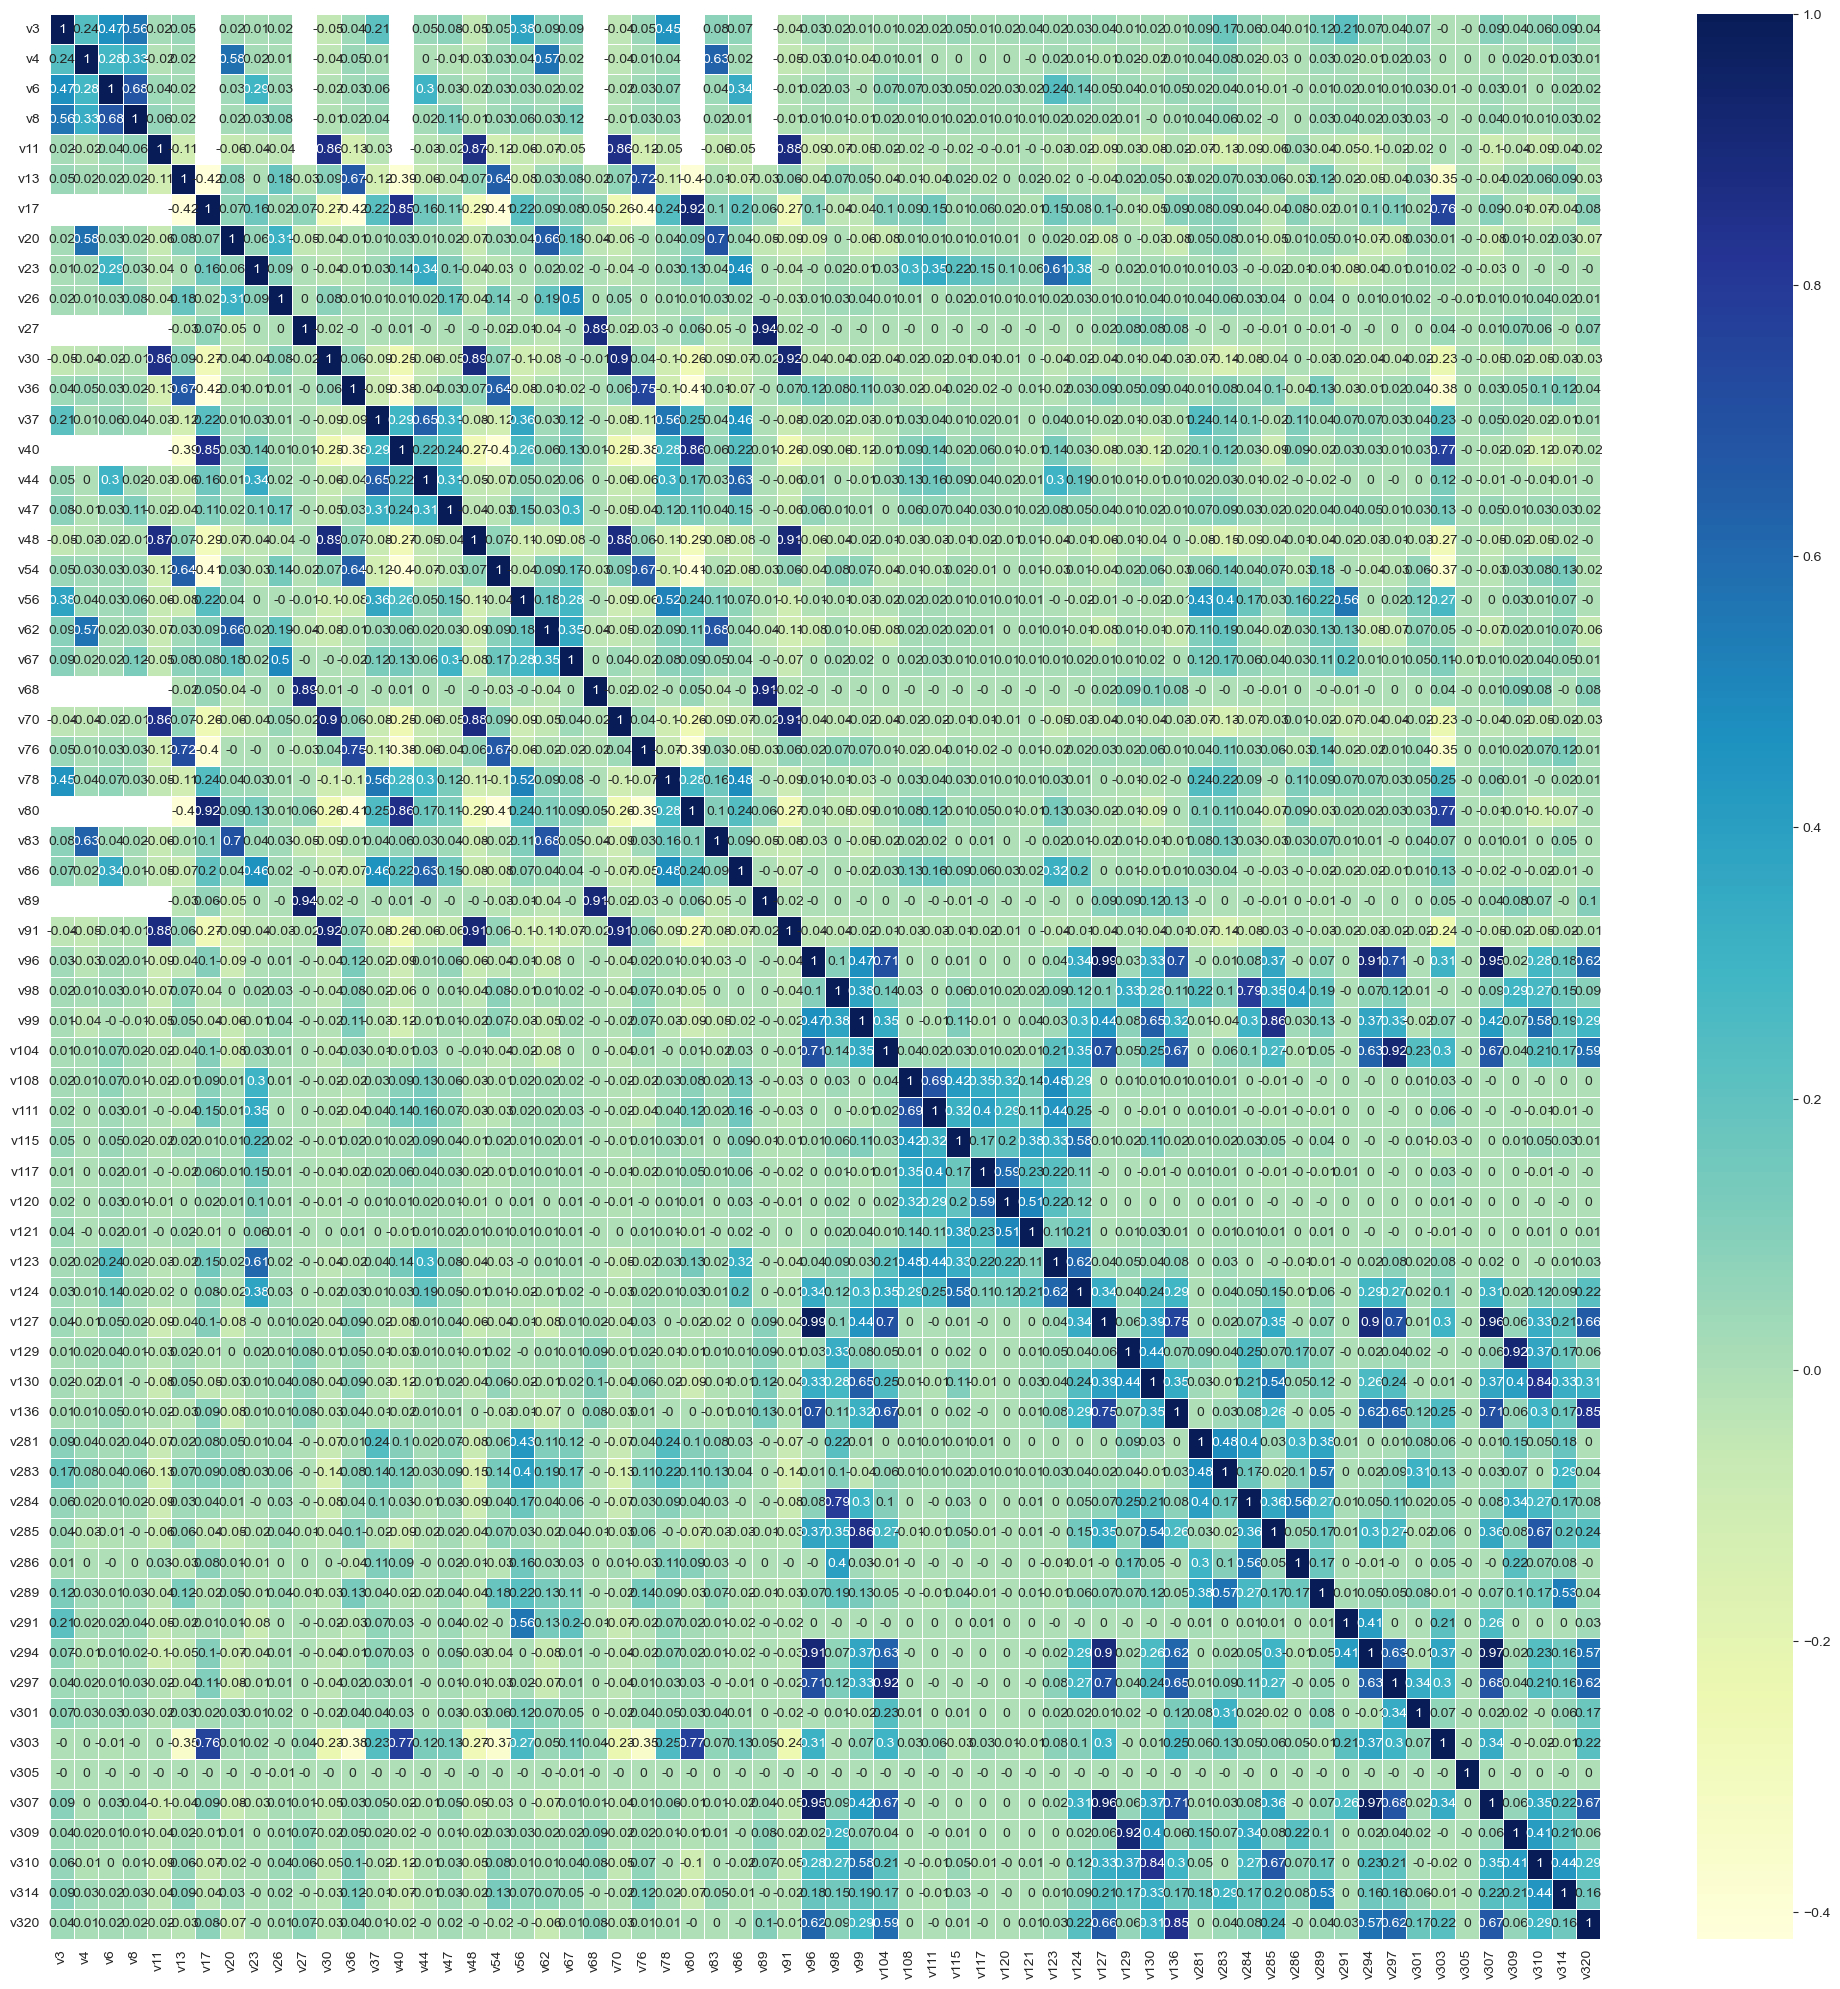

In [59]:
correlacion_vfinal = [
    'v3','v4','v6','v8','v11','v13','v17','v20','v23','v26','v27','v30',
    'v36','v37','v40','v44','v47','v48','v54','v56','v62','v67','v68','v70',
    'v76','v78','v80','v83','v86', 'v89','v91','v96','v98','v99', 'v104',
    'v108','v111','v115','v117','v120','v121','v123','v124','v127','v129','v130','v136',
    'v281','v283','v284','v285','v286','v289','v291','v294','v297', 'v301','v303','v305','v307','v309','v310','v314','v320'
]
plt.figure(figsize=(25,25))
sns.heatmap(round(fraud_df[correlacion_vfinal].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

## 7. Exportación de los datos

In [60]:
fraud_df.to_parquet("../data/processed/fraud_df_initial.parquet")